# Projet 8 : Traitement d'images pour le système embarqué d'une voiture autonome



## 🚗 Jeu de données

Nous utilisons le jeu de données [Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/) qui se concentre sur la compréhension sémantique des scènes urbaines.

Pour notre modèle de segmentation d'images, nous exploitons les **5 000 images annotées avec des annotations fines** (fine annotations).



Nous utilisons le jeu de données **Cityscapes** qui contient **5 000 images avec des annotations fines** :
- Entraînement : 2 975
- Validation : 500
- Test : 1 525

## Configuration de l'environnement et des dépendances

In [1]:
import os
import sys
import random
import json
import shutil
import zipfile
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import requests

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import data as tf_data
import keras
import keras_hub

# MLflow
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types import Schema, ColSpec, TensorSpec

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import keras
import mlflow
from dotenv import load_dotenv

# === CONFIGURATION TENSORFLOW / KERAS ===
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"CUDA disponible: {tf.config.list_physical_devices('GPU')}")

# === 1️⃣ DÉFINITION DES CHEMINS LOCAUX ===
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"

# Si ta data est directement ici (pas de sous-dossier)
data_dir = base_dir
cityscapes_dir = base_dir  # ou précise le dossier si tu as un sous-dossier spécifique

# Création de quelques dossiers utiles (modèles, logs, checkpoints)
os.makedirs(os.path.join(base_dir, 'models'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'models', 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'logs'), exist_ok=True)

# === 2️⃣ GÉNÉRATION DE GRAINES ===
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# === 3️⃣ CONFIGURATION MLFLOW & AWS ===
# Charger les variables depuis ton .env (si présent)
load_dotenv(os.path.join(base_dir, ".env"))

mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:5000")
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID", "")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY", "")

mlflow.set_tracking_uri(mlflow_tracking_uri)
print(f"MLflow Tracking URI: {mlflow_tracking_uri}")

# Config AWS (si utile)
if aws_access_key_id and aws_secret_access_key:
    os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
    os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
    print("Identifiants AWS configurés ✅")
else:
    print("⚠️ Aucun identifiant AWS trouvé (non nécessaire si MLflow local)")

# === 4️⃣ CONFIGURATION MLFLOW ===
mlflow.set_experiment("OC Projet 8")


TensorFlow version: 2.20.0
Keras version: 3.11.3
CUDA disponible: []
MLflow Tracking URI: http://127.0.0.1:5000
⚠️ Aucun identifiant AWS trouvé (non nécessaire si MLflow local)


<Experiment: artifact_location='mlflow-artifacts:/992620956726967536', creation_time=1760983823640, experiment_id='992620956726967536', last_update_time=1760983823640, lifecycle_stage='active', name='OC Projet 8', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [4]:
# Define target image size - use 224x224 which is more compatible with MobileNetV2
img_size = (224, 224)
batch_size = 8

## Téléchargement et préparation des données Cityscapes

In [5]:
import os
import shutil
import tensorflow as tf
import keras
import random
import numpy as np

# === 1️⃣ Configuration de base ===
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"CUDA disponible: {tf.config.list_physical_devices('GPU')}")

# === 2️⃣ Définition des chemins ===
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"
data_dir = os.path.join(base_dir, "Data")

# Dossiers des données déjà extraites
gtFine_dir = os.path.join(data_dir, "P8_Cityscapes_gtFine_trainvaltest")
leftImg_dir = os.path.join(data_dir, "P8_Cityscapes_leftImg8bit_trainvaltest")

# Vérification des dossiers existants
if not os.path.exists(gtFine_dir):
    raise FileNotFoundError(f"Dossier gtFine introuvable : {gtFine_dir}")
if not os.path.exists(leftImg_dir):
    raise FileNotFoundError(f"Dossier leftImg8bit introuvable : {leftImg_dir}")

print("✅ Dossiers Cityscapes trouvés :")
print(f"Annotations (gtFine) : {gtFine_dir}")
print(f"Images (leftImg8bit) : {leftImg_dir}")

# === 3️⃣ Prépare la structure attendue par les notebooks ===
cityscapes_dir = os.path.join(data_dir, "cityscapes")
os.makedirs(cityscapes_dir, exist_ok=True)

gtFine_target = os.path.join(cityscapes_dir, "gtFine")
leftImg_target = os.path.join(cityscapes_dir, "leftImg8bit")

# Copie seulement si nécessaire
def copy_folder_if_needed(src, dst):
    if not os.path.exists(dst):
        print(f"📂 Copie du dossier : {os.path.basename(src)} → {dst}")
        shutil.copytree(src, dst)
    else:
        print(f"✅ Dossier déjà présent : {dst}")

copy_folder_if_needed(gtFine_dir, gtFine_target)
copy_folder_if_needed(leftImg_dir, leftImg_target)

print(f"✅ cityscapes_dir prêt : {cityscapes_dir}")

# === 4️⃣ Configuration des graines ===
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


TensorFlow version: 2.20.0
Keras version: 3.11.3
CUDA disponible: []
✅ Dossiers Cityscapes trouvés :
Annotations (gtFine) : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\P8_Cityscapes_gtFine_trainvaltest
Images (leftImg8bit) : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\P8_Cityscapes_leftImg8bit_trainvaltest
✅ Dossier déjà présent : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\cityscapes\gtFine
✅ Dossier déjà présent : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\cityscapes\leftImg8bit
✅ cityscapes_dir prêt : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\cityscapes


## Définition des classes et mapping pour la segmentation

In [6]:
# Définition des classes Cityscapes par groupe selon la capture d'écran
class_groups = {
    'flat': ['road', 'sidewalk', 'parking', 'rail track'],
    'human': ['person', 'rider'],
    'vehicle': ['car', 'truck', 'bus', 'on rails', 'motorcycle', 'bicycle', 'caravan', 'trailer'],
    'construction': ['building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel'],
    'object': ['pole', 'pole group', 'traffic sign', 'traffic light'],
    'nature': ['vegetation', 'terrain'],
    'sky': ['sky'],
    'void': ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground']
}

# Définition du mapping entre les ID originaux de Cityscapes et nos groupes
cityscapes_mapping = {
    # void
    0: 7,  # 'unlabeled' -> 'void'
    1: 7,  # 'ego vehicle' -> 'void'
    2: 7,  # 'rectification border' -> 'void'
    3: 7,  # 'out of roi' -> 'void'
    4: 7,  # 'static' -> 'void'
    5: 7,  # 'dynamic' -> 'void'
    6: 7,  # 'ground' -> 'void'

    # flat
    7: 0,  # 'road' -> 'flat'
    8: 0,  # 'sidewalk' -> 'flat'
    9: 0,  # 'parking' -> 'flat'
    10: 0, # 'rail track' -> 'flat'

    # construction
    11: 3, # 'building' -> 'construction'
    12: 3, # 'wall' -> 'construction'
    13: 3, # 'fence' -> 'construction'
    14: 3, # 'guard rail' -> 'construction'
    15: 3, # 'bridge' -> 'construction'
    16: 3, # 'tunnel' -> 'construction'

    # object
    17: 4, # 'pole' -> 'object'
    18: 4, # 'pole group' -> 'object'
    19: 4, # 'traffic light' -> 'object'
    20: 4, # 'traffic sign' -> 'object'

    # nature
    21: 5, # 'vegetation' -> 'nature'
    22: 5, # 'terrain' -> 'nature'

    # sky
    23: 6, # 'sky' -> 'sky'

    # human
    24: 1, # 'person' -> 'human'
    25: 1, # 'rider' -> 'human'

    # vehicle
    26: 2, # 'car' -> 'vehicle'
    27: 2, # 'truck' -> 'vehicle'
    28: 2, # 'bus' -> 'vehicle'
    29: 2, # 'caravan' -> 'vehicle'
    30: 2, # 'trailer' -> 'vehicle'
    31: 2, # 'train' -> 'vehicle'
    32: 2, # 'motorcycle' -> 'vehicle'
    33: 2, # 'bicycle' -> 'vehicle'
}

# On crée un tableau pour faciliter la conversion des ID
id_to_group = np.zeros(256, dtype=np.uint8)
for id, group_id in cityscapes_mapping.items():
    id_to_group[id] = group_id

# Définition des couleurs pour la visualisation des groupes
group_colors = [
    [128, 64, 128],  # flat - bleu-gris
    [220, 20, 60],   # human - rouge
    [0, 0, 142],     # vehicle - bleu foncé
    [70, 70, 70],    # construction - gris
    [220, 220, 0],   # object - jaune
    [107, 142, 35],  # nature - vert
    [70, 130, 180],  # sky - bleu ciel
    [0, 0, 0]        # void - noir
]

# Noms des groupes
group_names = ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void']
num_classes = len(group_names)

## Préparation des données

In [7]:
# ✅ Fonction de préparation simple du dataset Cityscapes

def prepare_dataset(dataset_path, split='train', batch_size=8, img_size=(224, 224)):
    """
    Prépare un dataset Cityscapes à partir des fichiers bruts
    (images et masques) avec normalisation et augmentation simple.
    """

    images_dir = os.path.join(dataset_path, 'leftImg8bit', split)
    masks_dir = os.path.join(dataset_path, 'gtFine', split)

    # --- 1️⃣ Lister les chemins ---
    image_paths = []
    mask_paths = []

    for city in os.listdir(images_dir):
        city_img_dir = os.path.join(images_dir, city)
        city_mask_dir = os.path.join(masks_dir, city)

        for file_name in os.listdir(city_img_dir):
            if file_name.endswith('_leftImg8bit.png'):
                img_path = os.path.join(city_img_dir, file_name)
                mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                mask_path = os.path.join(city_mask_dir, mask_name)

                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)

    print(f"{split} dataset: {len(image_paths)} images found")

    # --- 2️⃣ Création du dataset TensorFlow ---
    path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # --- 3️⃣ Chargement et prétraitement des paires image/masque ---
    def load_and_preprocess(img_path, mask_path):
        # Image RGB
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, img_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0  # Normalisation [0,1]

        # Masque (label)
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, img_size, method='nearest')
        mask = tf.cast(mask, tf.int32)

        # Mapping des IDs Cityscapes → groupes de classes
        flat_mask = tf.reshape(mask, [-1])
        mapped_mask = tf.gather(tf.constant(id_to_group, dtype=tf.int32), flat_mask)
        mask = tf.reshape(mapped_mask, tf.shape(mask))
        mask = tf.squeeze(mask, axis=-1)  # 2D mask

        return img, mask

    dataset = path_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # --- 4️⃣ Augmentation simple (pour le split train uniquement) ---
    if split == 'train':
        def augment(image, mask):
            mask = tf.expand_dims(mask, axis=-1)

            # Flip horizontal aléatoire
            if tf.random.uniform(()) > 0.5:
                image = tf.image.flip_left_right(image)
                mask = tf.image.flip_left_right(mask)

            # Légère variation de luminosité
            image = tf.image.random_brightness(image, 0.1)
            image = tf.clip_by_value(image, 0, 1)

            mask = tf.squeeze(mask, axis=-1)
            return image, mask

        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    # --- 5️⃣ Batching et préchargement ---
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [8]:
# Prepare datasets directly from files with consistent size
train_dataset = prepare_dataset(cityscapes_dir, split='train', batch_size=batch_size, img_size=img_size)
val_dataset = prepare_dataset(cityscapes_dir, split='val', batch_size=batch_size, img_size=img_size)
test_dataset = prepare_dataset(cityscapes_dir, split='test', batch_size=batch_size, img_size=img_size)

train dataset: 2975 images found
val dataset: 500 images found
test dataset: 1525 images found


- `train_dataset` : pour l'entraînement
- `val_dataset` : pour la validation pendant l'entraînement

In [48]:
# Préparer les datasets avec la nouvelle approche
print("=== PRÉPARATION DES DATASETS ===")

# 1. Diviser le dataset 'train' original en train/val (80%/20%)
train_dataset, val_dataset = prepare_dataset_with_split(
    cityscapes_dir,
    split='train',
    batch_size=batch_size,
    img_size=img_size,
    validation_split=0.2
)

# 2. Utiliser le dataset 'val' original comme dataset de test final
test_dataset = prepare_dataset_with_split(
    cityscapes_dir,
    split='val',  # L'ancien 'val' devient notre 'test'
    batch_size=batch_size,
    img_size=img_size
)

print(f"\n✅ Datasets créés:")
print(f"   📚 Train: ~{2975 * 0.8:.0f} images (avec augmentation)")
print(f"   📊 Validation: ~{2975 * 0.2:.0f} images")
print(f"   🧪 Test: ~500 images (ancien dataset val)")

=== PRÉPARATION DES DATASETS ===
Train: 2380 images | Val: 595 images
Train: 400 images | Val: 100 images

✅ Datasets créés:
   📚 Train: ~2380 images (avec augmentation)
   📊 Validation: ~595 images
   🧪 Test: ~500 images (ancien dataset val)


Visualisation d'un échantillon du dataset d'entraînement:


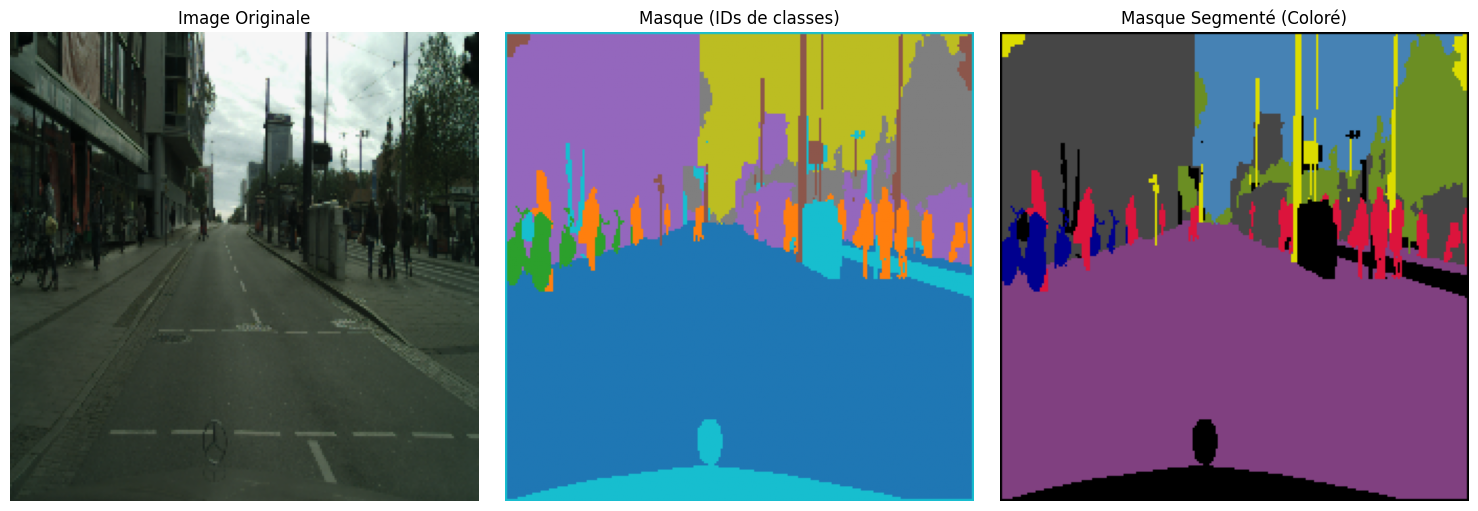


Classes présentes dans cette image:
  flat: 23640 pixels (47.1%)
  human: 1629 pixels (3.2%)
  vehicle: 771 pixels (1.5%)
  construction: 9749 pixels (19.4%)
  object: 1100 pixels (2.2%)
  nature: 3469 pixels (6.9%)
  sky: 5399 pixels (10.8%)
  void: 4419 pixels (8.8%)


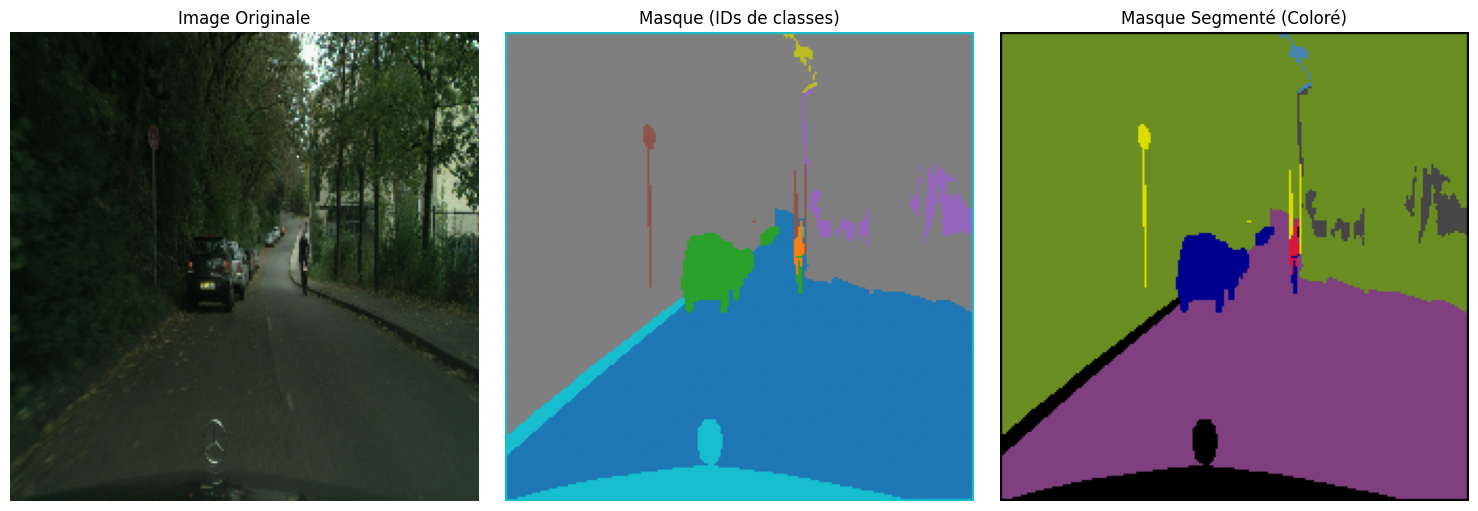


Classes présentes dans cette image:
  flat: 16987 pixels (33.9%)
  human: 70 pixels (0.1%)
  vehicle: 1011 pixels (2.0%)
  construction: 747 pixels (1.5%)
  object: 241 pixels (0.5%)
  nature: 27556 pixels (54.9%)
  sky: 83 pixels (0.2%)
  void: 3481 pixels (6.9%)

Visualisation d'un échantillon du dataset de validation:


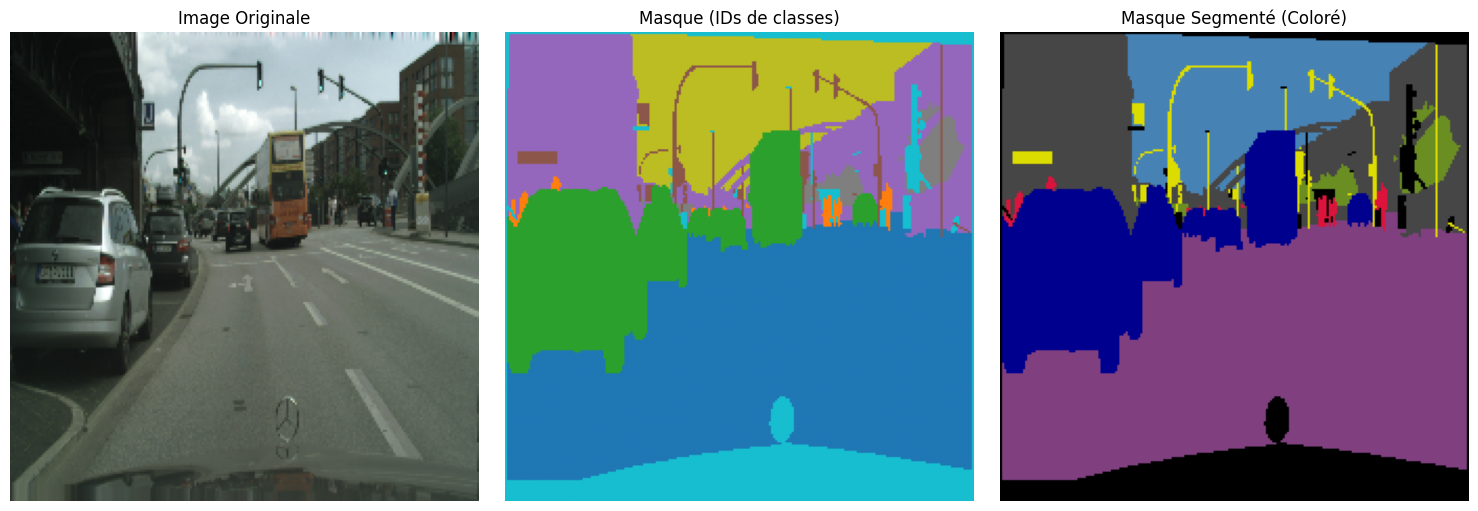


Classes présentes dans cette image:
  flat: 19593 pixels (39.0%)
  human: 269 pixels (0.5%)
  vehicle: 7581 pixels (15.1%)
  construction: 8500 pixels (16.9%)
  object: 942 pixels (1.9%)
  nature: 834 pixels (1.7%)
  sky: 6339 pixels (12.6%)
  void: 6118 pixels (12.2%)


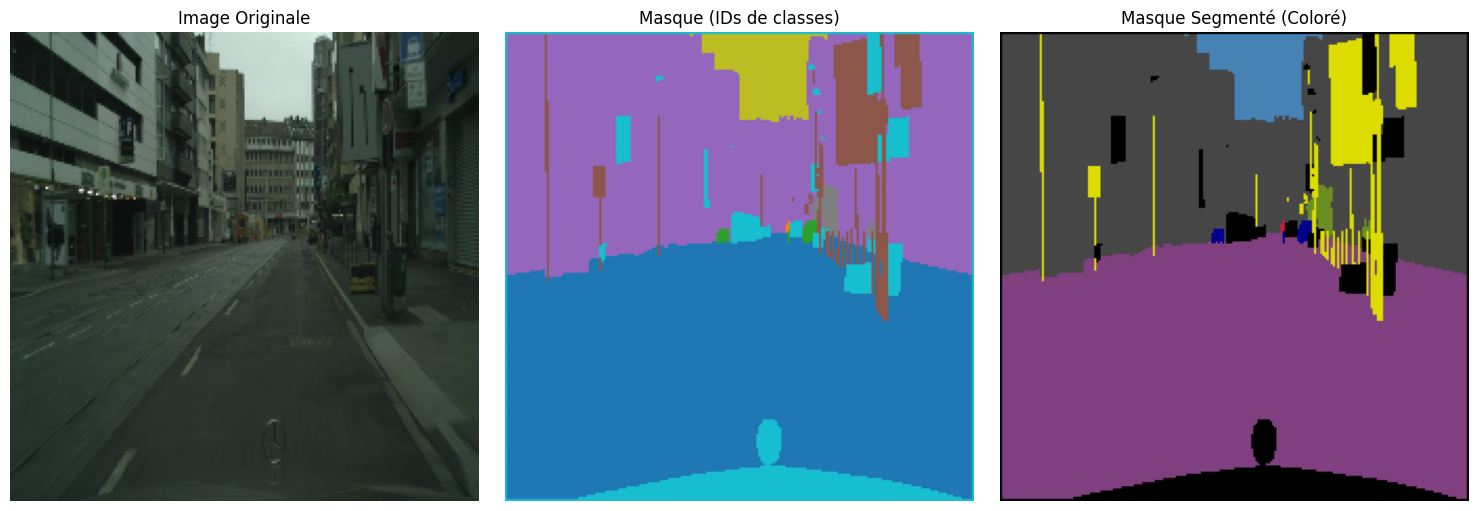


Classes présentes dans cette image:
  flat: 23395 pixels (46.6%)
  human: 9 pixels (0.0%)
  vehicle: 102 pixels (0.2%)
  construction: 17923 pixels (35.7%)
  object: 2695 pixels (5.4%)
  nature: 214 pixels (0.4%)
  sky: 1598 pixels (3.2%)
  void: 4240 pixels (8.5%)

Visualisation d'un échantillon du dataset de test:


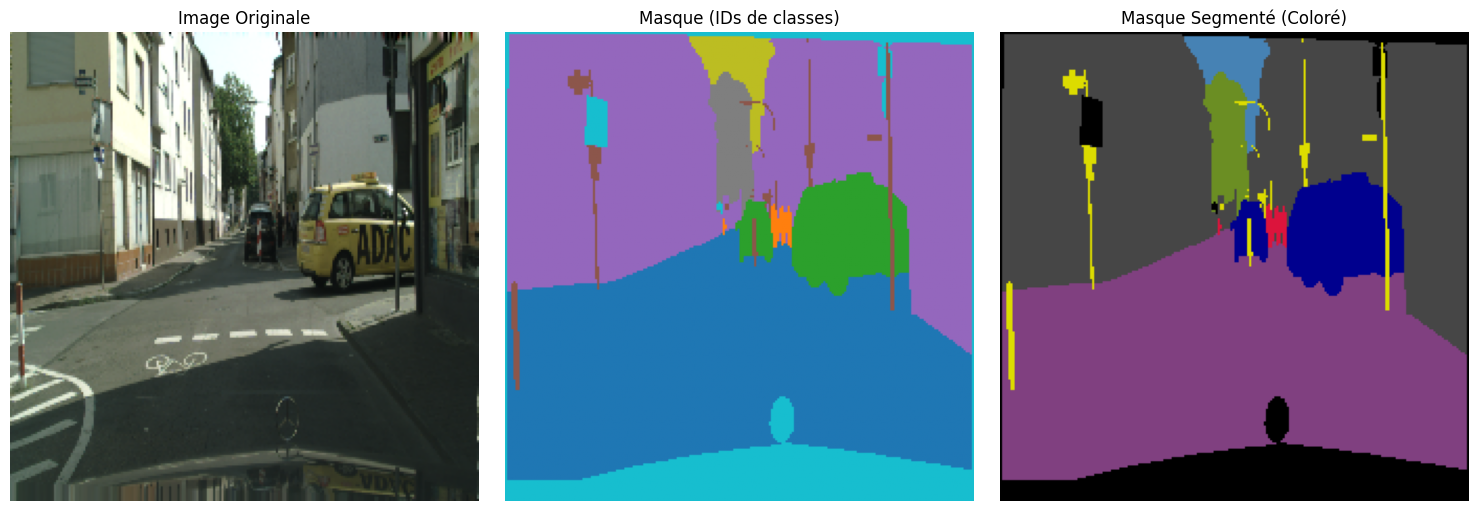


Classes présentes dans cette image:
  flat: 18943 pixels (37.8%)
  human: 165 pixels (0.3%)
  vehicle: 2759 pixels (5.5%)
  construction: 19632 pixels (39.1%)
  object: 873 pixels (1.7%)
  nature: 1013 pixels (2.0%)
  sky: 883 pixels (1.8%)
  void: 5908 pixels (11.8%)


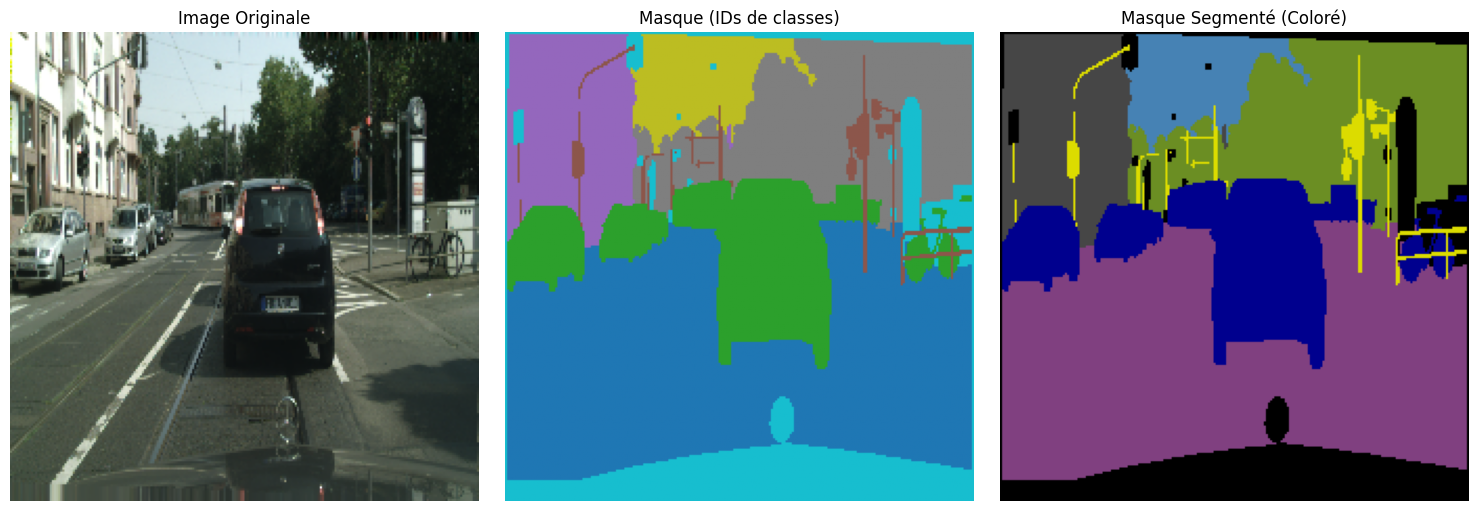


Classes présentes dans cette image:
  flat: 19355 pixels (38.6%)
  vehicle: 7172 pixels (14.3%)
  construction: 4946 pixels (9.9%)
  object: 1152 pixels (2.3%)
  nature: 7907 pixels (15.8%)
  sky: 2674 pixels (5.3%)
  void: 6970 pixels (13.9%)


In [37]:
# Visualisation d'un échantillon du dataset
def display_sample(dataset):
    """Affiche un échantillon d'images et de masques d'un dataset TensorFlow."""

    for batch in dataset.take(2):
        # Extraire les images et masques du tuple
        images, masks = batch  # Votre dataset retourne (images, masks)

        # Prendre le premier échantillon du batch
        image = images[0]
        mask = masks[0]  # Le masque est déjà 2D, pas besoin de squeeze

        plt.figure(figsize=(15, 5))

        # Afficher l'image originale
        plt.subplot(1, 3, 1)
        # L'image est normalisée [0,1], la multiplier par 255 pour l'affichage
        plt.imshow((image.numpy() * 255).astype("uint8"))
        plt.title("Image Originale")
        plt.axis("off")

        # Afficher le masque brut (en niveaux de gris)
        plt.subplot(1, 3, 2)
        plt.imshow(mask.numpy(), cmap='tab10', vmin=0, vmax=num_classes-1)
        plt.title("Masque (IDs de classes)")
        plt.axis("off")

        # Afficher le masque colorisé
        plt.subplot(1, 3, 3)
        # Convertir les ID de groupe en couleurs
        mask_array = mask.numpy()
        colored_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)

        for group_id in range(num_classes):
            colored_mask[mask_array == group_id] = group_colors[group_id]

        plt.imshow(colored_mask)
        plt.title("Masque Segmenté (Coloré)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        # Afficher les statistiques des classes présentes
        unique_classes, counts = np.unique(mask_array, return_counts=True)
        print("\nClasses présentes dans cette image:")
        for class_id, count in zip(unique_classes, counts):
            percentage = (count / mask_array.size) * 100
            print(f"  {group_names[class_id]}: {count} pixels ({percentage:.1f}%)")

# Visualiser un échantillon du dataset d'entraînement
print("Visualisation d'un échantillon du dataset d'entraînement:")
display_sample(train_dataset)

# Visualiser un échantillon du dataset de validation
print("\nVisualisation d'un échantillon du dataset de validation:")
display_sample(val_dataset)

# Optionnel: Visualiser aussi le dataset de test
print("\nVisualisation d'un échantillon du dataset de test:")
display_sample(test_dataset)

## Visualisation des données

Visualisation de 3 échantillons du jeu de données train
Sauvegardé à: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\samples\train_samples.png


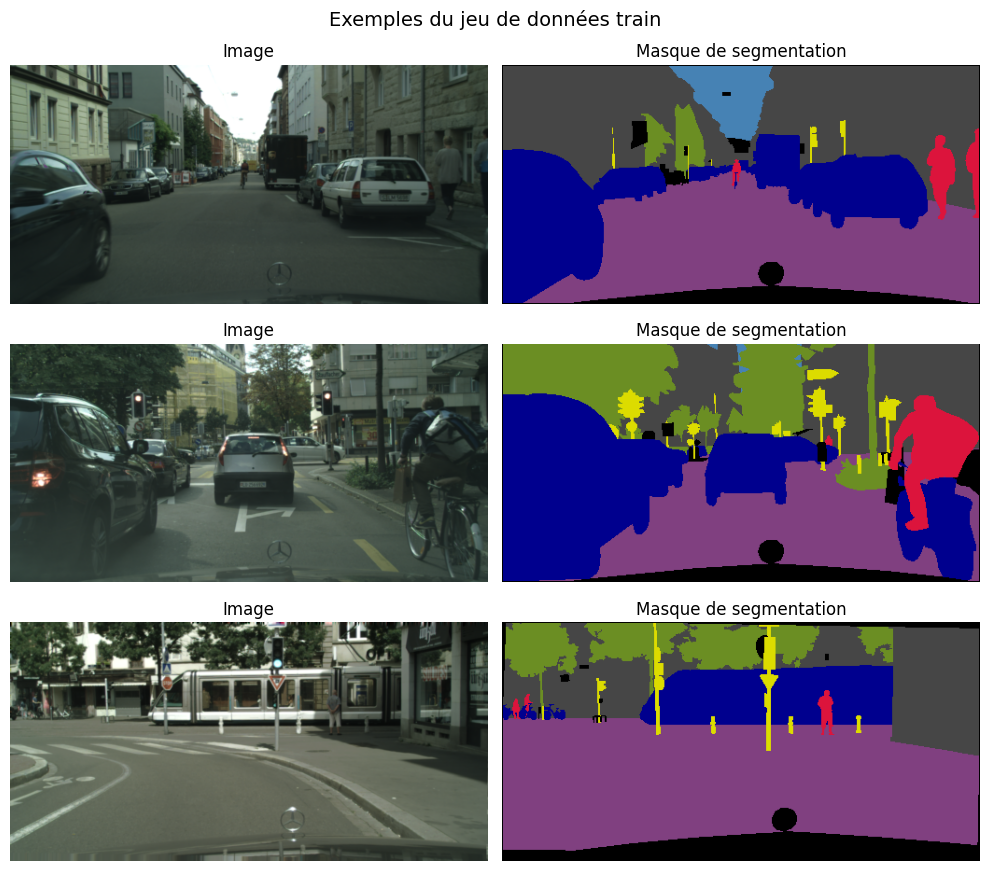


Visualisation de 3 échantillons du jeu de données val
Sauvegardé à: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\samples\val_samples.png


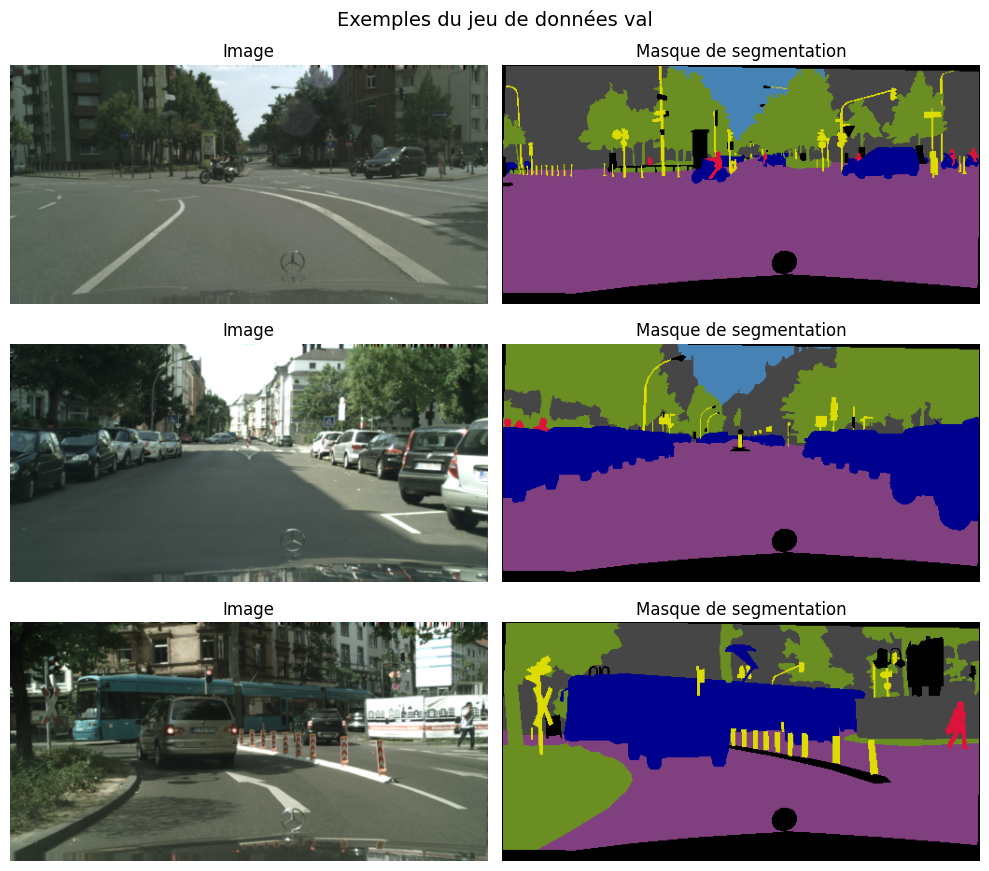


Visualisation de 3 échantillons du jeu de données test
Sauvegardé à: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\samples\test_samples.png


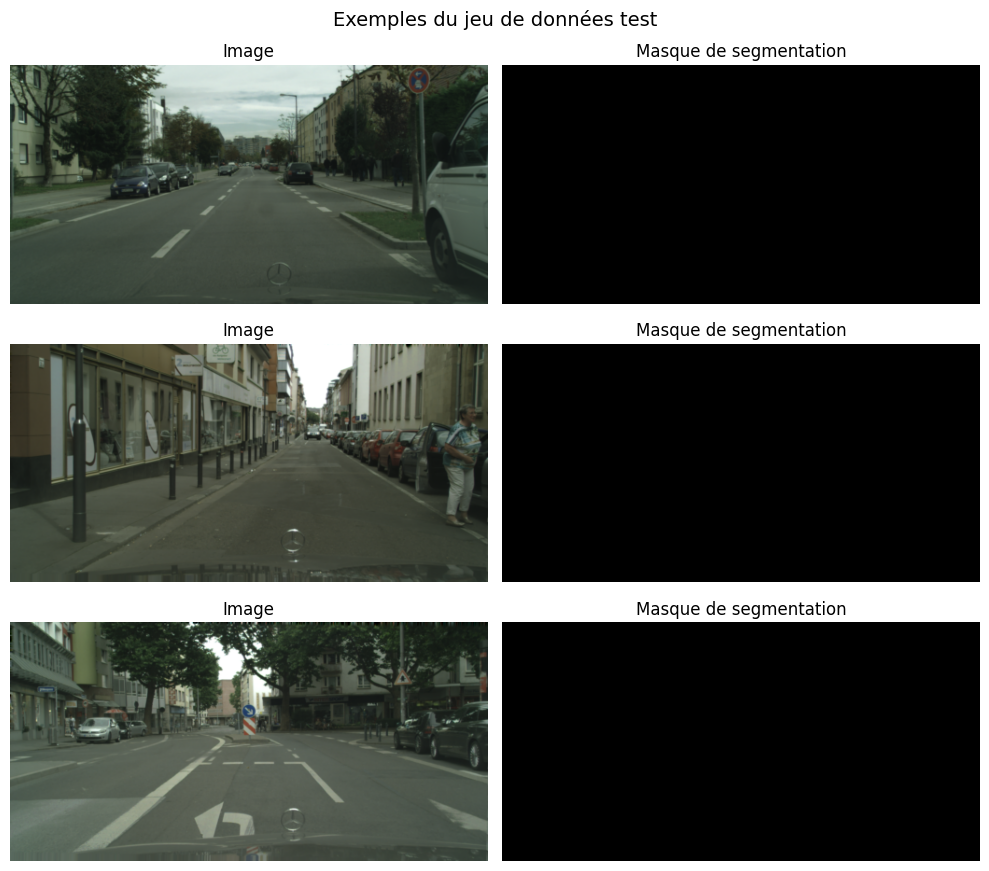


Légende sauvegardée à: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Data\samples\class_legend.png


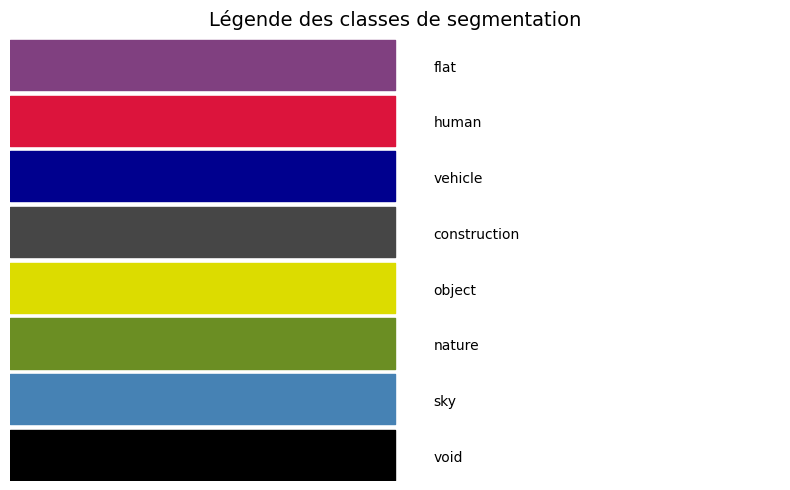

In [28]:
def visualize_dataset_samples(root_dir, split='train', num_samples=3):
    """
    Visualise quelques exemples aléatoires du jeu de données avec leurs masques de segmentation

    Arguments:
        root_dir: Répertoire racine des données Cityscapes
        split: 'train' ou 'val'
        num_samples: Nombre d'échantillons à visualiser
    """
    # Chemins des répertoires
    images_dir = os.path.join(root_dir, 'leftImg8bit', split)
    masks_dir = os.path.join(root_dir, 'gtFine', split)

    # Listes pour stocker les chemins des images et des masques
    image_paths = []
    mask_paths = []

    # Parcourir les répertoires de villes pour trouver toutes les images
    for city in os.listdir(images_dir):
        city_img_dir = os.path.join(images_dir, city)
        city_mask_dir = os.path.join(masks_dir, city)

        for file_name in os.listdir(city_img_dir):
            if file_name.endswith('_leftImg8bit.png'):
                img_path = os.path.join(city_img_dir, file_name)
                mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                mask_path = os.path.join(city_mask_dir, mask_name)

                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)

    # Sélection aléatoire des images
    selected_indices = np.random.choice(len(image_paths), size=min(num_samples, len(image_paths)), replace=False)
    selected_img_paths = [image_paths[i] for i in selected_indices]
    selected_mask_paths = [mask_paths[i] for i in selected_indices]

    # Création d'une figure pour afficher les images et masques
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3*num_samples))

    plt.suptitle(f"Exemples du jeu de données {split}", fontsize=14)

    for i, (img_path, mask_path) in enumerate(zip(selected_img_paths, selected_mask_paths)):
        # Chargement de l'image avec PIL (plus légère)
        img = np.array(Image.open(img_path).resize((512, 256), Image.BILINEAR))

        # Chargement du masque avec PIL
        mask_raw = np.array(Image.open(mask_path).resize((512, 256), Image.NEAREST))

        # Conversion du masque aux groupes définis
        mask = id_to_group[mask_raw]

        # Création du masque coloré
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for class_idx in range(num_classes):
            colored_mask[mask == class_idx] = group_colors[class_idx]

        # Affichage
        if num_samples == 1:
            axes[0].imshow(img)
            axes[0].set_title("Image")
            axes[0].axis('off')

            axes[1].imshow(colored_mask)
            axes[1].set_title("Masque de segmentation")
            axes[1].axis('off')
        else:
            axes[i, 0].imshow(img)
            axes[i, 0].set_title("Image")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(colored_mask)
            axes[i, 1].set_title("Masque de segmentation")
            axes[i, 1].axis('off')

    plt.tight_layout()

    # Création du dossier pour les visualisations
    viz_dir = os.path.join(data_dir, 'samples')
    os.makedirs(viz_dir, exist_ok=True)

    # Sauvegarde de la figure
    fig_path = os.path.join(viz_dir, f'{split}_samples.png')
    fig.savefig(fig_path)

    print(f"Visualisation de {num_samples} échantillons du jeu de données {split}")
    print(f"Sauvegardé à: {fig_path}")

    return fig

# Visualisation de quelques échantillons du jeu d'entraînement
train_fig = visualize_dataset_samples(cityscapes_dir, split='train', num_samples=3)
plt.show()
plt.close(train_fig)
print()

# Visualisation de quelques échantillons du jeu de validation
val_fig = visualize_dataset_samples(cityscapes_dir, split='val', num_samples=3)
plt.show()
plt.close(val_fig)
print()

# Visualisation de quelques échantillons du jeu de test
test_fig = visualize_dataset_samples(cityscapes_dir, split='test', num_samples=3)
plt.show()
plt.close(test_fig)
print()

# Création de la légende des classes
def create_class_legend(class_names, class_colors, output_dir=None):
    """Crée une légende pour les classes de segmentation"""

    plt.figure(figsize=(8, 5))

    plt.title("Légende des classes de segmentation", fontsize=14)

    for i, (name, color) in enumerate(zip(class_names, class_colors)):
        plt.fill_between([0, 1], [i, i], [i+0.9, i+0.9], color=[c/255 for c in color])
        plt.text(1.1, i+0.5, name, va='center')

    plt.xlim(0, 2)
    plt.ylim(len(class_names)-0.1, -0.1)
    plt.axis('off')
    plt.tight_layout()

    if output_dir:
        legend_path = os.path.join(output_dir, 'class_legend.png')
        plt.savefig(legend_path)
        print(f"Légende sauvegardée à: {legend_path}")

    return plt.gcf()

# Création de la légende des classes
viz_dir = os.path.join(data_dir, 'samples')
legend_fig = create_class_legend(group_names, group_colors, output_dir=viz_dir)
plt.show()
plt.close(legend_fig)

## Architecture de Segmentation MobileNetV2-UNet



Cette architecture combine la puissance de MobileNetV2 (un réseau léger et efficace) avec la structure en forme de U de l'architecture U-Net pour réaliser une segmentation d'images. Voici une explication simple de cette architecture :

## Structure Générale

* **Forme en U** : L'architecture suit une forme en "U" avec une partie descendante (encodeur) et une partie ascendante (décodeur).
* **Objectif** : Attribuer une classe à chaque pixel de l'image (segmentation).

## Partie Encodeur (Descendante)

* **Base MobileNetV2** : On utilise MobileNetV2 comme encodeur, un réseau conçu pour être léger et efficace sur des appareils mobiles.
* **Couches gelées** : `base_model.trainable = False` - Les poids pré-entraînés de MobileNetV2 sont "gelés" pour accélérer l'entraînement initial.
* **Points de connexion** : On extrait les caractéristiques à différents niveaux de résolution :
  * skip1 : niveau 112×112
  * skip2 : niveau 56×56
  * skip3 : niveau 28×28
  * skip4 : niveau 14×14
  * bottleneck : niveau 7×7 (point le plus bas de l'architecture en U)

## Partie Décodeur (Ascendante)

* **Upsampling progressif** : On remonte progressivement de la résolution la plus basse à la résolution originale.
* **Connexions résiduelles (Skip connections)** : On connecte chaque niveau du décodeur avec le niveau correspondant de l'encodeur pour préserver les détails spatiaux.
* **Convolutions Transposes** : Utilisées pour augmenter la résolution à chaque étape :
  * 7×7 → 14×14
  * 14×14 → 28×28
  * 28×28 → 56×56
  * 56×56 → 112×112
  * 112×112 → 224×224

## Détails Techniques

* **Normalisation par lots (BatchNormalization)** : Après chaque couche de convolution pour stabiliser l'apprentissage.
* **Activation ReLU** : Fonction d'activation non-linéaire après chaque couche.
* **Concaténation** : Les caractéristiques du même niveau de l'encodeur sont concaténées avec celles du décodeur.
* **Couche finale** : Une convolution 1×1 avec activation softmax qui produit la probabilité d'appartenance à chaque classe pour chaque pixel.




In [11]:
# Configuration des expériences

# Experience 1 : Avec Data Augmentation
#EXPERIMENT_CONFIG = {
#    "exp_name": "exp_001_baseline",  # Changez cette valeur pour chaque run
#    "description": "Baseline MobileNetV2-UNet avec frozen encoder",
#    "params": {
#        "learning_rate": 0.0001,
#        "batch_size": 8,
#        "epochs": 20,
#        "base_model_trainable": False,
#        "validation_split": 0.2,
#        "augmentation": True
#    }
#}

# Experience 2 : Sans Data Augmentation
EXPERIMENT_CONFIG = {
    "exp_name": "exp_002_no_augmentation",
    "description": "MobileNetV2-UNet avec frozen encoder, sans data augmentation",
    "params": {
        "learning_rate": 0.0001,
        "batch_size": 8,
        "epochs": 20,
        "base_model_trainable": False,
        "validation_split": 0.2,
        "augmentation": False
    }
}

# Exemples d'autres configurations :
# EXPERIMENT_CONFIG = {
#     "exp_name": "exp_002_unfrozen",
#     "description": "MobileNetV2-UNet avec encoder trainable",
#     "params": {
#         "learning_rate": 0.00005,
#         "batch_size": 8,
#         "epochs": 20,
#         "base_model_trainable": True,
#         "validation_split": 0.2,
#         "augmentation": True
#     }
# }

In [12]:
import os

def setup_experiment_paths(base_dir, experiment_name):
    """
    Crée la structure de dossiers pour une expérience dans:
    <base_dir>/experiments/<experiment_name>/
    """
    exp_dir = os.path.join(base_dir, "experiments", experiment_name)

    paths = {
        'exp_dir': exp_dir,
        'models_dir': os.path.join(exp_dir, 'models'),
        'checkpoints_dir': os.path.join(exp_dir, 'models', 'checkpoints'),
        'logs_dir': os.path.join(exp_dir, 'logs'),
        'results_dir': os.path.join(exp_dir, 'results'),
        'visualizations_dir': os.path.join(exp_dir, 'visualizations'),
    }

    # Créer tous les dossiers
    for p in paths.values():
        os.makedirs(p, exist_ok=True)

    return paths

# --- Utilisation locale ---
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"  # adapte si besoin
exp_paths = setup_experiment_paths(base_dir, EXPERIMENT_CONFIG["exp_name"])
print(f"Dossier d'expérience: {exp_paths['exp_dir']}")


Dossier d'expérience: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation


In [13]:
import os, json

# Nom de l'expérience à partir de la config
experiment_name = EXPERIMENT_CONFIG["exp_name"]

# Dossier de base de ton projet
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"

# Dossier cible pour les résultats de l’expérience
config_path = os.path.join(base_dir, "experiments", experiment_name, "results", "experiment_config.json")

# Créer le dossier parent si nécessaire
os.makedirs(os.path.dirname(config_path), exist_ok=True)

# Sauvegarder la configuration dans un fichier JSON
with open(config_path, "w") as f:
    json.dump(EXPERIMENT_CONFIG, f, indent=4)

print(f"✅ Configuration sauvegardée : {config_path}")


✅ Configuration sauvegardée : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation\results\experiment_config.json


In [14]:
import os, json

def verify_experiment_config(base_dir, experiment_name):
    """
    Vérifie qu'une configuration d'expérience a bien été sauvegardée
    et l'affiche joliment.
    """
    config_path = os.path.join(base_dir, "experiments", experiment_name, "results", "experiment_config.json")

    if os.path.exists(config_path):
        with open(config_path, "r") as f:
            loaded_config = json.load(f)

        print(f"✅ Configuration chargée pour {experiment_name}:")
        print(json.dumps(loaded_config, indent=2))
        return loaded_config
    else:
        print(f"❌ Configuration non trouvée pour {experiment_name}")
        print(f"Chemin cherché : {config_path}")
        return None


# 🔹 Test d'exécution locale
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"
verify_experiment_config(base_dir, "exp_002_no_augmentation")


✅ Configuration chargée pour exp_002_no_augmentation:
{
  "exp_name": "exp_002_no_augmentation",
  "description": "MobileNetV2-UNet avec frozen encoder, sans data augmentation",
  "params": {
    "learning_rate": 0.0001,
    "batch_size": 8,
    "epochs": 20,
    "base_model_trainable": false,
    "validation_split": 0.2,
    "augmentation": false
  }
}


{'exp_name': 'exp_002_no_augmentation',
 'description': 'MobileNetV2-UNet avec frozen encoder, sans data augmentation',
 'params': {'learning_rate': 0.0001,
  'batch_size': 8,
  'epochs': 20,
  'base_model_trainable': False,
  'validation_split': 0.2,
  'augmentation': False}}

### Création du modèle

In [15]:
def create_segmentation_model(num_classes=8, input_size=(224, 224, 3),
                            learning_rate=0.0001, base_trainable=False):
    """
    Create a segmentation model with configurable parameters
    """
    # Input tensor
    inputs = keras.layers.Input(shape=input_size)

    # Create MobileNetV2 base model
    base_model = keras.applications.MobileNetV2(
        input_shape=input_size,
        include_top=False,
        weights='imagenet'
    )

    # Configuration de l'entraînement du modèle de base
    base_model.trainable = base_trainable

    # Create encoder using MobileNetV2
    # Get outputs at different levels for skip connections
    skip1 = base_model.get_layer('block_1_expand_relu').output      # 112x112
    skip2 = base_model.get_layer('block_3_expand_relu').output      # 56x56
    skip3 = base_model.get_layer('block_6_expand_relu').output      # 28x28
    skip4 = base_model.get_layer('block_13_expand_relu').output     # 14x14

    # Get bottleneck
    bottleneck = base_model.get_layer('block_16_project').output    # 7x7

    # Use Model API to create encoder model
    encoder = keras.Model(inputs=base_model.input, outputs=[skip1, skip2, skip3, skip4, bottleneck])

    # Encoder part - use the encoder model
    x = inputs
    skips = encoder(x)

    # Bottleneck
    x = skips[4]  # Use the bottleneck from encoder

    # Decoder part - upsampling and skip connections
    # First upsampling: 7x7 -> 14x14
    x = keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Concatenate()([x, skips[3]])
    x = keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    # Second upsampling: 14x14 -> 28x28
    x = keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Concatenate()([x, skips[2]])
    x = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    # Third upsampling: 28x28 -> 56x56
    x = keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Concatenate()([x, skips[1]])
    x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    # Fourth upsampling: 56x56 -> 112x112
    x = keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Concatenate()([x, skips[0]])
    x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    # Final upsampling: 112x112 -> 224x224
    x = keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)

    # Output layer
    outputs = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(x)

    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs, name="MobileNetV2-UNet")

    # Compile model avec learning rate configurable
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
            # keras.metrics.MeanIoU(num_classes=num_classes)
        ]
    )

    return model

In [16]:
# Create the model with compatible input size
model = create_segmentation_model(num_classes=num_classes, input_size=(img_size[0], img_size[1], 3))
print()
model.summary()

Model: "MobileNetV2-UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 112, 112, │  1,841,984 │ input_layer[0][0] │
│ (Functional)        │ 96), (None, 56,   │            │                   │
│                     │ 56, 144), (None,  │            │                   │
│                     │ 28, 28, 192),     │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 576), (None, 7,   │            │                   │
│                     │ 7, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    737,536 │ functional[0][4]  │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ activation[0][0], │
│ (Concatenate)       │ 832)              │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │  1,917,184 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │    295,040 │ conv2d[0][0]      │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ activation_1[0][… │
│ (Concatenate)       │ 320)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │    368,768 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 56, 56,    │     73,792 │ conv2d_1[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                 

 Total params: 5,418,600 (20.67 MB)

 Trainable params: 3,575,624 (13.64 MB)

 Non-trainable params: 1,842,976 (7.03 MB)

### Visualisation de l'architecture du modèle

In [17]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Générer le diagramme
plot_model(
    model,
    to_file='unet_architecture_simple.png',
    show_shapes=True,           # Affiche les dimensions des tenseurs
    show_layer_names=True,      # Affiche les noms des couches
    rankdir='LR',              # Layout horizontal (Left to Right)
    expand_nested=False,        # Développe les modèles imbriqués
    dpi=150                    # Résolution
)

# Afficher l'image
from IPython.display import Image
Image('unet_architecture_simple.png')

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


FileNotFoundError: No such file or directory: 'unet_architecture_simple.png'

FileNotFoundError: No such file or directory: 'unet_architecture_simple.png'

<IPython.core.display.Image object>

### Entraînement du modèle

In [18]:
def train_model_with_config(model, train_dataset, val_dataset, config, paths):
    """
    Entraîne le modèle avec une configuration donnée
    """
    exp_name = config["exp_name"]
    params = config["params"]

    # Set up training callbacks avec les nouveaux chemins
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            verbose=1,
            min_lr=1e-6
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(paths['checkpoints_dir'], 'best_model.keras'),
            monitor='val_sparse_categorical_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        keras.callbacks.TensorBoard(
            log_dir=os.path.join(paths['logs_dir'], datetime.now().strftime('%Y%m%d-%H%M%S')),
            histogram_freq=1
        )
    ]

    # MLflow callback
    class ExperimentMLflowCallback(keras.callbacks.Callback):
        def __init__(self, config, paths):
            super().__init__()
            self.config = config
            self.paths = paths

        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            for name, value in logs.items():
                mlflow.log_metric(name, value, step=epoch)

        def on_train_begin(self, logs=None):
            # Log tous les paramètres de configuration
            mlflow.log_params(self.config["params"])
            mlflow.log_param("experiment_name", self.config["exp_name"])
            mlflow.log_param("description", self.config["description"])

    # Set up MLflow experiment
    mlflow.set_experiment("OC Projet 8")
    with mlflow.start_run(run_name=exp_name):
        # Add MLflow callback
        mlflow_callback = ExperimentMLflowCallback(config, paths)
        callbacks.append(mlflow_callback)

        # Train the model
        print(f"🚀 Starting training for experiment: {exp_name}")
        print(f"📝 Description: {config['description']}")
        print(f"📊 Parameters: {params}")

        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=params["epochs"],
            callbacks=callbacks,
            verbose=1
        )

        # Save artifacts dans le dossier de l'expérience
        save_experiment_artifacts(model, history, config, paths)

        # Log artifacts to MLflow
        mlflow.log_artifacts(paths['results_dir'])

        return history

def save_experiment_artifacts(model, history, config, paths):
    """
    Sauvegarde tous les artefacts de l'expérience
    """
    # 1. Sauvegarder le modèle final
    final_model_path = os.path.join(paths['models_dir'], "cityscapes_segmentation_model.keras")
    model.save(final_model_path)
    print(f"📁 Modèle sauvegardé: {final_model_path}")

    # 2. Sauvegarder la configuration
    config_path = os.path.join(paths['results_dir'], "experiment_config.json")
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)

    # 3. Sauvegarder l'historique d'entraînement
    history_path = os.path.join(paths['results_dir'], "training_history.json")
    with open(history_path, 'w') as f:
        # Convertir les numpy arrays en listes pour JSON
        history_dict = {}
        for key, values in history.history.items():
            history_dict[key] = [float(v) for v in values]
        json.dump(history_dict, f, indent=4)

    # 4. Créer et sauvegarder les graphiques
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot learning rate if available
    plt.subplot(1, 3, 3)
    if 'learning_rate' in history.history:
        plt.plot(history.history['learning_rate'])
        plt.title('Learning Rate')
        plt.ylabel('LR')
        plt.xlabel('Epoch')
    else:
        plt.text(0.5, 0.5, 'No LR data', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plots_path = os.path.join(paths['visualizations_dir'], 'training_plots.png')
    plt.savefig(plots_path, dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Sauvegarder le mapping des classes
    class_mapping = {
        'id_to_group': id_to_group.tolist(),
        'group_names': group_names,
        'group_colors': group_colors,
        'num_classes': num_classes
    }

    mapping_path = os.path.join(paths['models_dir'], 'class_mapping.json')
    with open(mapping_path, 'w') as f:
        json.dump(class_mapping, f, indent=4)

    print(f"📊 Artefacts sauvegardés dans: {paths['exp_dir']}")

In [54]:
def prepare_dataset_with_split(dataset_path, split='train', batch_size=8, img_size=(224, 224), validation_split=0.2):
    """
    Prépare automatiquement un dataset Cityscapes avec séparation train/val.
    Si split='val', retourne un seul dataset (utilisé pour le test).
    """
    import tensorflow as tf
    import os
    import numpy as np

    def load_and_preprocess(img_path, mask_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, img_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, img_size, method='nearest')
        mask = tf.cast(mask, tf.int32)

        # Mapping des classes Cityscapes → 8 groupes
        flat_mask = tf.reshape(mask, [-1])
        mapped_mask = tf.gather(tf.constant(id_to_group, dtype=tf.int32), flat_mask)
        mask = tf.reshape(mapped_mask, tf.shape(mask))
        mask = tf.squeeze(mask, axis=-1)
        return img, mask

    images_dir = os.path.join(dataset_path, 'leftImg8bit', split)
    masks_dir = os.path.join(dataset_path, 'gtFine', split)

    image_paths, mask_paths = [], []
    for city in os.listdir(images_dir):
        city_img_dir = os.path.join(images_dir, city)
        city_mask_dir = os.path.join(masks_dir, city)
        for file_name in os.listdir(city_img_dir):
            if file_name.endswith('_leftImg8bit.png'):
                img_path = os.path.join(city_img_dir, file_name)
                mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                mask_path = os.path.join(city_mask_dir, mask_name)
                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)

    total_size = len(image_paths)

    # 🧩 Cas 1 : split='val' → dataset unique (test)
    if split == 'val':
        print(f"🧪 Mode test détecté : {total_size} images dans {split}")
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # 🧩 Cas 2 : split='train' → découpage train/val
    val_size = int(total_size * validation_split)
    rng = np.random.default_rng(seed=42)
    indices = np.arange(total_size)
    rng.shuffle(indices)

    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    train_imgs = [image_paths[i] for i in train_indices]
    train_masks = [mask_paths[i] for i in train_indices]
    val_imgs = [image_paths[i] for i in val_indices]
    val_masks = [mask_paths[i] for i in val_indices]

    print(f"Train: {len(train_imgs)} images | Val: {len(val_imgs)} images")

    def make_dataset(imgs, masks, augment=False):
        dataset = tf.data.Dataset.from_tensor_slices((imgs, masks))
        dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        if augment:
            def augment_fn(image, mask):
                mask = tf.expand_dims(mask, axis=-1)
                if tf.random.uniform(()) > 0.5:
                    image = tf.image.flip_left_right(image)
                    mask = tf.image.flip_left_right(mask)
                image = tf.image.random_brightness(image, 0.1)
                image = tf.clip_by_value(image, 0, 1)
                mask = tf.squeeze(mask, axis=-1)
                return image, mask
            dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    train_ds = make_dataset(train_imgs, train_masks, augment=True)
    val_ds = make_dataset(val_imgs, val_masks, augment=False)
    return train_ds, val_ds


In [25]:
def prepare_test_dataset(dataset_path, batch_size=8, img_size=(224, 224)):
    """
    Prépare le dataset de test Cityscapes (avec le même mapping que train/val)
    """
    import tensorflow as tf, os, numpy as np

    def load_and_preprocess(img_path, mask_path):
        # Lecture + normalisation image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, img_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0

        # Lecture + mapping masque
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, img_size, method='nearest')
        mask = tf.cast(mask, tf.int32)

        # 🟢 Appliquer le même mapping des classes Cityscapes vers groupes
        flat_mask = tf.reshape(mask, [-1])
        mapped_mask = tf.gather(tf.constant(id_to_group, dtype=tf.int32), flat_mask)
        mask = tf.reshape(mapped_mask, tf.shape(mask))
        mask = tf.squeeze(mask, axis=-1)

        return img, mask

    images_dir = os.path.join(dataset_path, 'leftImg8bit', 'val')
    masks_dir = os.path.join(dataset_path, 'gtFine', 'val')

    image_paths, mask_paths = [], []
    for city in os.listdir(images_dir):
        for file_name in os.listdir(os.path.join(images_dir, city)):
            if file_name.endswith('_leftImg8bit.png'):
                img_path = os.path.join(images_dir, city, file_name)
                mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                mask_path = os.path.join(masks_dir, city, mask_name)
                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [46]:
cityscapes_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\data\cityscapes"
test_dataset = prepare_test_dataset(cityscapes_dir, batch_size=8)


Train: 2380 images | Val: 595 images


2025/10/25 14:31:41 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



🚀 Starting training for experiment: exp_002_no_augmentation
📝 Description: MobileNetV2-UNet avec frozen encoder, sans data augmentation
📊 Parameters: {'learning_rate': 0.0001, 'batch_size': 8, 'epochs': 20, 'base_model_trainable': False, 'validation_split': 0.2, 'augmentation': False}
Epoch 1/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 1.6030 - sparse_categorical_accuracy: 0.4452
Epoch 1: val_sparse_categorical_accuracy improved from None to 0.77396, saving model to C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation\models\checkpoints\best_model.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 189s 612ms/step - loss: 1.2692 - sparse_categorical_accuracy: 0.5976 - val_loss: 0.9167 - val_sparse_categorical_accuracy: 0.7740 - learning_rate: 1.0000e-04
Epoch 2/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.7438 - sparse_categorical_accuracy: 0.7845
Epoch 2: val_sparse_categorical_accuracy improved from 0.77396 to 0.83778, saving m

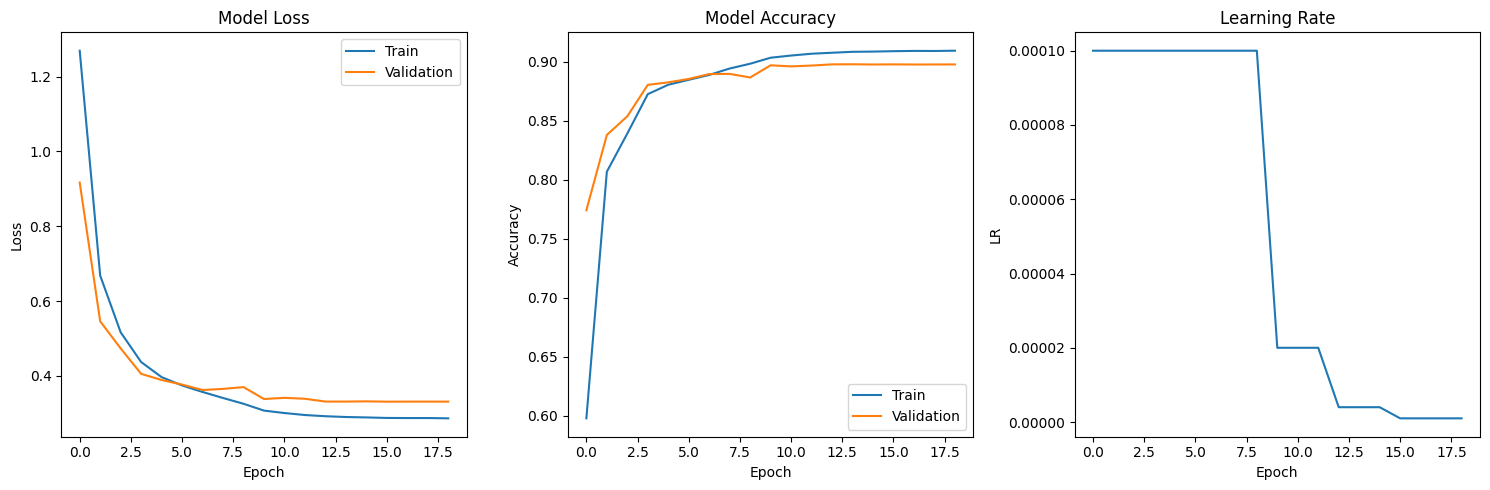

📊 Artefacts sauvegardés dans: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation
🏃 View run exp_002_no_augmentation at: http://127.0.0.1:5000/#/experiments/992620956726967536/runs/051bb13860b040daa41c720d73b4ccc5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/992620956726967536
✅ Expérience exp_002_no_augmentation terminée !
📁 Résultats sauvegardés dans : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation


In [21]:
# Code principal pour l'entraînement
TRAIN = True

if TRAIN:
    # 1️⃣ Définir le dossier de base du projet 
    base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"

    # 2️⃣ Création automatique de la structure d'expérience
    exp_paths = setup_experiment_paths(base_dir, EXPERIMENT_CONFIG["exp_name"])

    # 3️⃣ Créer le modèle avec les paramètres de configuration
    model = create_segmentation_model(
        num_classes=num_classes,
        input_size=(img_size[0], img_size[1], 3),
        learning_rate=EXPERIMENT_CONFIG["params"]["learning_rate"],
        base_trainable=EXPERIMENT_CONFIG["params"]["base_model_trainable"]
    )

    # 4️⃣ Préparer les datasets (train/val)
    batch_size = EXPERIMENT_CONFIG["params"]["batch_size"]

    train_dataset, val_dataset = prepare_dataset_with_split(
        cityscapes_dir,
        split='train',
        batch_size=batch_size,
        img_size=img_size,
        validation_split=EXPERIMENT_CONFIG["params"]["validation_split"]
    )

    # 5️⃣ Entraîner le modèle
    history = train_model_with_config(
        model,
        train_dataset,
        val_dataset,
        EXPERIMENT_CONFIG,
        exp_paths
    )

    print(f"✅ Expérience {EXPERIMENT_CONFIG['exp_name']} terminée !")
    print(f"📁 Résultats sauvegardés dans : {exp_paths['exp_dir']}")


## Évaluation du modèle

In [27]:
import os, json
from datetime import datetime
import tensorflow as tf

def load_and_evaluate_experiment(experiment_name, test_dataset, base_dir):
    # Charger le modèle final
    model_path = os.path.join(base_dir, "experiments", experiment_name, "models", "cityscapes_segmentation_model.keras")

    print(f"📁 Chargement du modèle depuis: {model_path}")

    # Vérifier l’existence du fichier
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ Modèle non trouvé: {model_path}")

    # Charger le modèle
    model = tf.keras.models.load_model(model_path)
    print("✅ Modèle chargé avec succès !")

    # Charger la config si disponible
    config_path = os.path.join(base_dir, "experiments", experiment_name, "results", "experiment_config.json")
    if os.path.exists(config_path):
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)
        print(f"🧾 Description: {config.get('description', 'N/A')}")

    # Évaluation sur le dataset de test
    print("\n🧪 Évaluation sur le dataset de test...")
    test_results = model.evaluate(test_dataset, verbose=1)

    # Résultats formatés
    results_dict = {}
    for metric_name, value in zip(model.metrics_names, test_results):
        results_dict[f"test_{metric_name}"] = float(value)
        print(f"   {metric_name}: {value:.4f}")

    # Sauvegarde
    test_results_path = os.path.join(base_dir, "experiments", experiment_name, "results", "test_results.json")
    os.makedirs(os.path.dirname(test_results_path), exist_ok=True)
    with open(test_results_path, 'w', encoding='utf-8') as f:
        json.dump({
            'test_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'results': results_dict
        }, f, indent=4)

    print(f"\n💾 Résultats sauvegardés dans: {test_results_path}")
    return results_dict, model


# === Utilisation ===
experiment_name = "exp_002_no_augmentation"
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"

results, trained_model = load_and_evaluate_experiment(experiment_name, test_dataset, base_dir)


📁 Chargement du modèle depuis: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation\models\cityscapes_segmentation_model.keras
✅ Modèle chargé avec succès !
🧾 Description: MobileNetV2-UNet avec frozen encoder, sans data augmentation

🧪 Évaluation sur le dataset de test...
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 0.3947 - sparse_categorical_accuracy: 0.8789
   loss: 0.3947
   compile_metrics: 0.8789

💾 Résultats sauvegardés dans: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation\results\test_results.json


🔍 ÉVALUATION DÉTAILLÉE DU MODÈLE
📁 Répertoire de sauvegarde: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation\results

📊 1. MÉTRIQUES DE BASE
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - loss: 0.3947 - sparse_categorical_accuracy: 0.8789

📋 Métriques de base:
       Métrique  Valeur
           loss  0.3947
compile_metrics  0.8789
💾 Sauvegardé: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation\results\base_metrics.csv

🎯 2. COLLECTE DES PRÉDICTIONS
   Batch 1 traité...
   Batch 11 traité...
   Batch 21 traité...
   Batch 31 traité...
   Batch 41 traité...
   Batch 51 traité...
   Batch 61 traité...
   Total d'images évaluées: 500

📈 3. IoU PAR CLASSE
      Classe    IoU  Pixels_Vrais_%  Pixels_Prédits_%
        flat 0.9088         38.0088           39.6337
       human 0.3549          1.3213            1.4865
     vehicle 0.7435          7.0752            7.2212
construction 0.

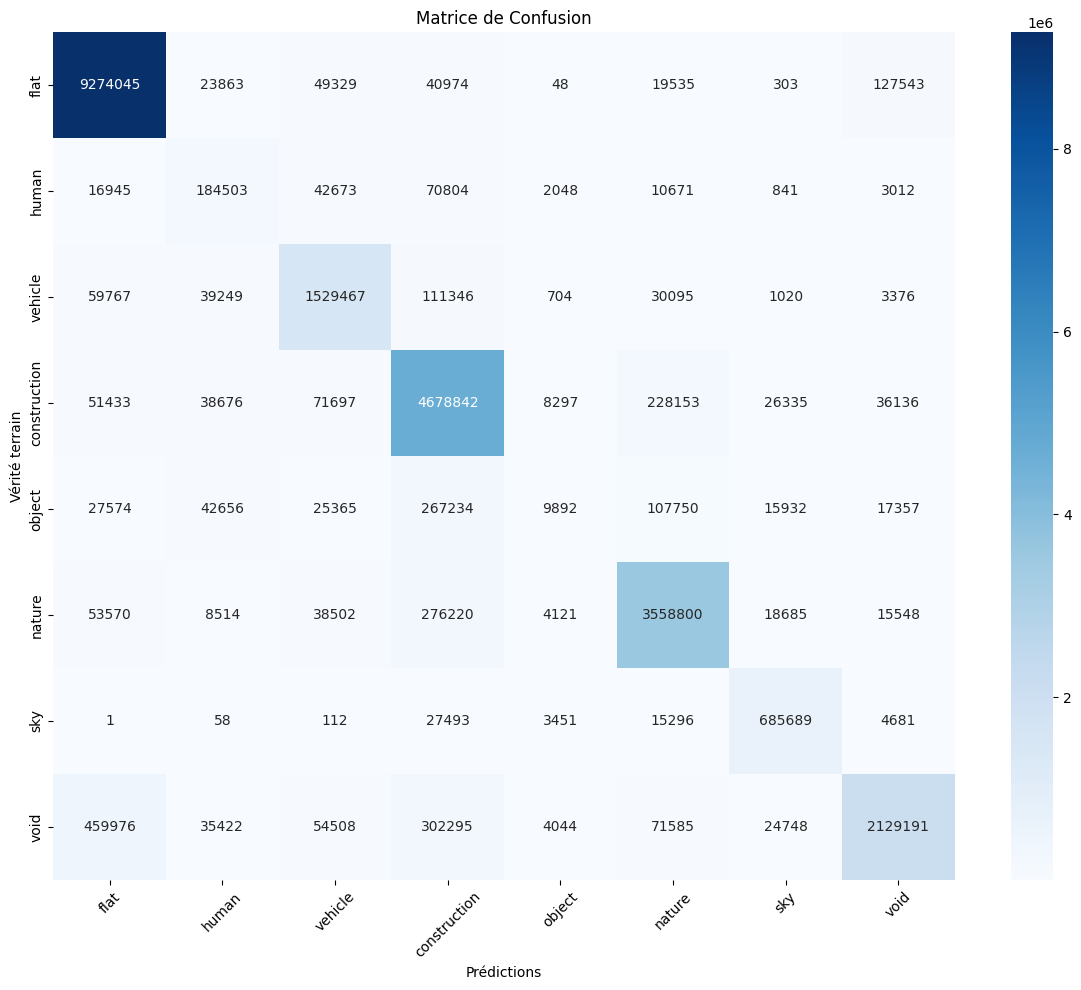

🖼️ Exemples de prédictions sauvegardés: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation\results\prediction_examples.png


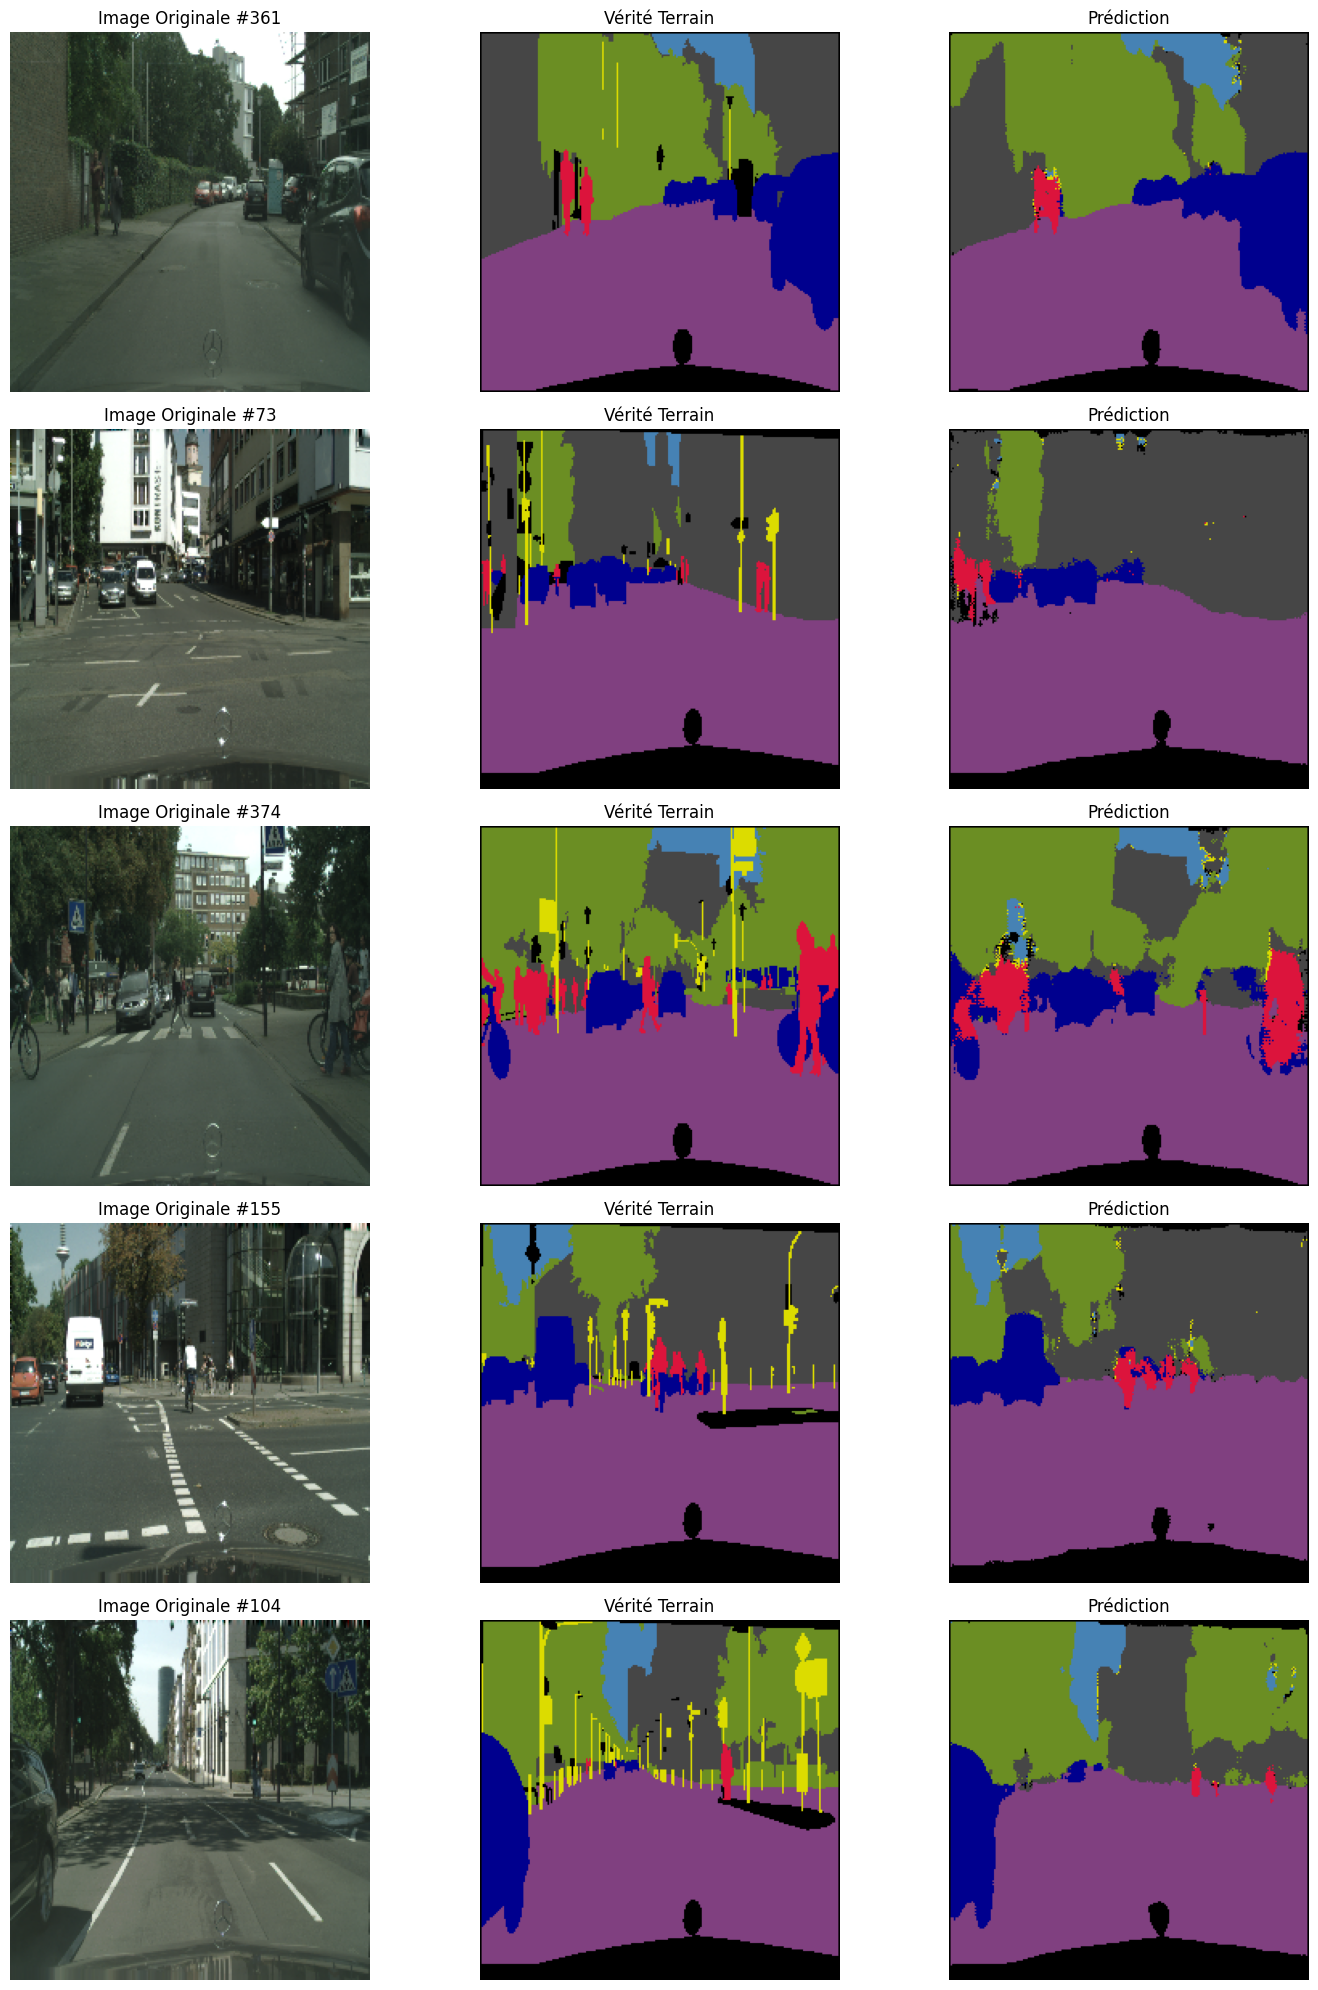


✅ Évaluation terminée. Tous les fichiers sauvegardés dans:
C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation\results

🎯 Accès rapide aux DataFrames:
- results['iou_df']
- results['classification_df']
- results['cm_df']


In [28]:
# @title
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

def detailed_evaluation(model, test_dataset, class_names, class_colors, experiment_name=None, save_dir=None):
    """
    Évaluation détaillée du modèle avec métriques complètes (version locale)
    """

    # === 🔧 1. Définir le répertoire de sauvegarde ===
    base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"

    if save_dir is None and experiment_name:
        save_dir = os.path.join(base_dir, "experiments", experiment_name, "results")
    elif save_dir is None:
        save_dir = os.path.join(base_dir, "evaluation_results")

    os.makedirs(save_dir, exist_ok=True)

    print("🔍 ÉVALUATION DÉTAILLÉE DU MODÈLE")
    print("=" * 50)
    print(f"📁 Répertoire de sauvegarde: {save_dir}")

    # === 📊 2. Métriques de base ===
    print("\n📊 1. MÉTRIQUES DE BASE")
    test_results = model.evaluate(test_dataset, verbose=1)

    base_metrics_df = pd.DataFrame({
        "Métrique": model.metrics_names,
        "Valeur": test_results
    })

    print("\n📋 Métriques de base:")
    print(base_metrics_df.to_string(index=False, float_format="%.4f"))

    base_metrics_path = os.path.join(save_dir, "base_metrics.csv")
    base_metrics_df.to_csv(base_metrics_path, index=False)
    print(f"💾 Sauvegardé: {base_metrics_path}")

    # === 🎯 3. Collecte des prédictions ===
    print("\n🎯 2. COLLECTE DES PRÉDICTIONS")
    all_true_masks, all_pred_masks, all_images = [], [], []

    for batch_idx, (images, true_masks) in enumerate(test_dataset):
        predictions = model.predict(images, verbose=0)
        pred_masks = tf.argmax(predictions, axis=-1)
        all_images.extend(images.numpy())
        all_true_masks.extend(true_masks.numpy())
        all_pred_masks.extend(pred_masks.numpy())

        if batch_idx % 10 == 0:
            print(f"   Batch {batch_idx + 1} traité...")

    all_true_masks = np.array(all_true_masks)
    all_pred_masks = np.array(all_pred_masks)
    all_images = np.array(all_images)
    print(f"   Total d'images évaluées: {len(all_true_masks)}")

    # === 📈 4. IoU par classe ===
    print("\n📈 3. IoU PAR CLASSE")

    iou_data, ious = [], []
    total_pixels = all_true_masks.size

    for class_id in range(len(class_names)):
        true_binary = (all_true_masks == class_id)
        pred_binary = (all_pred_masks == class_id)

        intersection = np.logical_and(true_binary, pred_binary).sum()
        union = np.logical_or(true_binary, pred_binary).sum()
        iou = intersection / union if union > 0 else 0.0

        ious.append(iou)
        iou_data.append({
            "Classe": class_names[class_id],
            "IoU": iou,
            "Pixels_Vrais_%": 100 * true_binary.sum() / total_pixels,
            "Pixels_Prédits_%": 100 * pred_binary.sum() / total_pixels
        })

    iou_df = pd.DataFrame(iou_data)
    mean_iou = np.mean(ious)
    print(iou_df.to_string(index=False, float_format="%.4f"))
    print(f"\n📊 MEAN IoU: {mean_iou:.4f}")

    iou_path = os.path.join(save_dir, "iou_per_class.csv")
    iou_df.to_csv(iou_path, index=False)
    print(f"💾 Sauvegardé: {iou_path}")

    # === 📋 5. Rapport de classification ===
    y_true_flat = all_true_masks.flatten()
    y_pred_flat = all_pred_masks.flatten()

    report = classification_report(
        y_true_flat, y_pred_flat,
        target_names=class_names,
        output_dict=True, zero_division=0
    )

    classification_df = pd.DataFrame([
        {
            "Classe": cls,
            "Précision": m["precision"],
            "Rappel": m["recall"],
            "F1-Score": m["f1-score"],
            "Support": int(m["support"])
        }
        for cls, m in report.items() if cls not in ("accuracy", "macro avg", "weighted avg")
    ])

    print("\n📊 Rapport de classification:")
    print(classification_df.to_string(index=False, float_format="%.4f"))

    classification_path = os.path.join(save_dir, "classification_report.csv")
    classification_df.to_csv(classification_path, index=False)
    print(f"💾 Sauvegardé: {classification_path}")

    # === 🔢 6. Matrice de confusion ===
    print("\n🔢 MATRICE DE CONFUSION")
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    print(cm_df.to_string())

    cm_path = os.path.join(save_dir, "confusion_matrix.csv")
    cm_df.to_csv(cm_path)
    print(f"💾 Sauvegardé: {cm_path}")

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Matrice de Confusion")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérité terrain")
    plt.xticks(rotation=45)
    plt.tight_layout()

    cm_viz_path = os.path.join(save_dir, "confusion_matrix.png")
    plt.savefig(cm_viz_path, dpi=300, bbox_inches="tight")
    print(f"🖼️ Visualisation sauvegardée: {cm_viz_path}")
    plt.show()

    # === 🖼️ 7. Visualisation des prédictions ===
    visualize_predictions_detailed(all_images, all_true_masks, all_pred_masks,
                                 class_names, class_colors, num_samples=5, save_dir=save_dir)

    print("\n✅ Évaluation terminée. Tous les fichiers sauvegardés dans:")
    print(save_dir)
    return {
        "accuracy": report["accuracy"],
        "mean_iou": mean_iou,
        "iou_df": iou_df,
        "classification_df": classification_df,
        "cm_df": cm_df
    }


def visualize_predictions_detailed(images, true_masks, pred_masks, class_names, class_colors, num_samples=5, save_dir=None):
    """Visualise des exemples de prédictions"""
    indices = np.random.choice(len(images), size=min(num_samples, len(images)), replace=False)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))

    for i, idx in enumerate(indices):
        axes[i, 0].imshow((images[idx] * 255).astype(np.uint8))
        axes[i, 0].set_title(f"Image Originale #{idx}")
        axes[i, 0].axis("off")

        true_colored = np.zeros((*true_masks[idx].shape, 3), dtype=np.uint8)
        pred_colored = np.zeros((*pred_masks[idx].shape, 3), dtype=np.uint8)
        for class_id in range(len(class_names)):
            true_colored[true_masks[idx] == class_id] = class_colors[class_id]
            pred_colored[pred_masks[idx] == class_id] = class_colors[class_id]

        axes[i, 1].imshow(true_colored)
        axes[i, 1].set_title("Vérité Terrain")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title("Prédiction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    if save_dir:
        out_path = os.path.join(save_dir, "prediction_examples.png")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"🖼️ Exemples de prédictions sauvegardés: {out_path}")
    plt.show()


# === 🧪 Utilisation ===
results = detailed_evaluation(
    trained_model,
    test_dataset,
    group_names,
    group_colors,
    experiment_name=experiment_name
)

print("\n🎯 Accès rapide aux DataFrames:")
print("- results['iou_df']")
print("- results['classification_df']")
print("- results['cm_df']")


# Exp03

In [44]:
# === EXP_003 : Fine-tuning MobileNetV2 (encoder dégelé) ===

import os, json, tensorflow as tf
import numpy as np

# 1️⃣ Charger le modèle exp_002 existant
src_experiment = "exp_002_no_augmentation"
src_model_path = os.path.join(base_dir, "experiments", src_experiment, "models", "cityscapes_segmentation_model.keras")

finetune_model = tf.keras.models.load_model(src_model_path)
print("✅ Modèle exp_002 rechargé.")

# 2️⃣ Dégeler les couches du backbone (correction)
unfrozen = 0
for layer in finetune_model.layers:
    # Beaucoup de modèles sauvegardés perdent le mot "mobilenet" dans le nom
    # Donc on cible plutôt les couches convolutionnelles (conv / depthwise)
    if "conv" in layer.name.lower() or "depthwise" in layer.name.lower():
        layer.trainable = True
        unfrozen += 1

print(f"🧩 Nombre de couches convolutionnelles dégelées : {unfrozen}")

# (Optionnel) Vérifier combien de couches sont maintenant entraînables
trainable_count = np.sum([layer.trainable for layer in finetune_model.layers])
print(f"🔍 Total couches entraînables : {trainable_count} / {len(finetune_model.layers)}")

# 3️⃣ Recompiler avec un LR plus faible (pour le fine-tuning)
finetune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

print("🔁 Modèle recompilé pour fine-tuning (lr=1e-5).")


✅ Modèle exp_002 rechargé.
🧩 Nombre de couches convolutionnelles dégelées : 11
🔍 Total couches entraînables : 27 / 27
🔁 Modèle recompilé pour fine-tuning (lr=1e-5).


**Entraînement + Sauvegarde du modèle fine-tuné:**

In [50]:
# === EXP_003 : Fine-tuning MobileNetV2 (encoder dégelé) ===

import os, json, tensorflow as tf

# 1️⃣ Charger le modèle exp_002 existant
src_experiment = "exp_002_no_augmentation"
src_model_path = os.path.join(base_dir, "experiments", src_experiment, "models", "cityscapes_segmentation_model.keras")
finetune_model = tf.keras.models.load_model(src_model_path)
print("✅ Modèle exp_002 rechargé.")

# 2️⃣ Dégeler les couches MobileNetV2 (pour fine-tuning)
unfrozen = 0
for layer in finetune_model.layers:
    if "mobilenet" in layer.name.lower():
        layer.trainable = True
        unfrozen += 1
print(f"🧩 Nombre de couches convolutionnelles dégelées : {unfrozen}")
print(f"🔍 Total couches entraînables : {len(finetune_model.trainable_variables)}")

# 3️⃣ Recompiler avec un LR plus faible
finetune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)
print("🔁 Modèle recompilé pour fine-tuning (lr=1e-5).")

# 4️⃣ Fine-tuning sur le dataset original
fine_tune_epochs = 5

print("🚀 Démarrage de l'entraînement fine-tuning...")

# 🟢 ⚠️ Utilisation de tes variables existantes : train_dataset / val_dataset
history_ft = finetune_model.fit(
    train_dataset,                 # ✅ ton jeu d’entraînement existant
    validation_data=val_dataset,   # ✅ ton jeu de validation existant
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

# 5️⃣ Sauvegarde de l’historique
hist_ft = {k: [float(x) for x in v] for k, v in history_ft.history.items()}

# 6️⃣ Sauvegarde du modèle fine-tuné
exp_name = "exp_003_finetune"
save_dir = os.path.join(base_dir, "experiments", exp_name)
os.makedirs(os.path.join(save_dir, "models"), exist_ok=True)
os.makedirs(os.path.join(save_dir, "results"), exist_ok=True)

model_path = os.path.join(save_dir, "models", "cityscapes_segmentation_model.keras")
finetune_model.save(model_path)
print(f"💾 Modèle fine-tuné sauvegardé dans : {model_path}")

# 7️⃣ Sauvegarde de l’historique
history_path = os.path.join(save_dir, "results", "training_history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(hist_ft, f, indent=4)
print(f"💾 Historique sauvegardé dans : {history_path}")


✅ Modèle exp_002 rechargé.
🧩 Nombre de couches convolutionnelles dégelées : 0
🔍 Total couches entraînables : 32
🔁 Modèle recompilé pour fine-tuning (lr=1e-5).
🚀 Démarrage de l'entraînement fine-tuning...
Epoch 1/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 193s 628ms/step - loss: 0.2889 - sparse_categorical_accuracy: 0.9084 - val_loss: 0.3326 - val_sparse_categorical_accuracy: 0.8977
Epoch 2/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 195s 605ms/step - loss: 0.2869 - sparse_categorical_accuracy: 0.9088 - val_loss: 0.3327 - val_sparse_categorical_accuracy: 0.8976
Epoch 3/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 176s 591ms/step - loss: 0.2849 - sparse_categorical_accuracy: 0.9095 - val_loss: 0.3330 - val_sparse_categorical_accuracy: 0.8976
Epoch 4/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 176s 588ms/step - loss: 0.2832 - sparse_categorical_accuracy: 0.9100 - val_loss: 0.3340 - val_sparse_categorical_accuracy: 0.8974
Epoch 5/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 172s 575ms/step - loss: 0.2810 - sparse_categorical_accuracy: 0.9107 - val_loss: 

In [55]:
cityscapes_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\data\cityscapes"
test_dataset = prepare_dataset_with_split(cityscapes_dir, split='val', batch_size=8)

🧪 Mode test détecté : 500 images dans val


In [56]:
results, trained_model = load_and_evaluate_experiment("exp_003_finetune", test_dataset, base_dir)

📁 Chargement du modèle depuis: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_003_finetune\models\cityscapes_segmentation_model.keras
✅ Modèle chargé avec succès !

🧪 Évaluation sur le dataset de test...
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.3992 - sparse_categorical_accuracy: 0.8788
   loss: 0.3992
   compile_metrics: 0.8788

💾 Résultats sauvegardés dans: C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_003_finetune\results\test_results.json


In [60]:
import os, json

src_exp = "exp_002_no_augmentation"
dst_exp = "exp_003_finetune"

src_config = os.path.join(base_dir, "experiments", src_exp, "results", "experiment_config.json")
dst_config_dir = os.path.join(base_dir, "experiments", dst_exp, "results")
dst_config = os.path.join(dst_config_dir, "experiment_config.json")

os.makedirs(dst_config_dir, exist_ok=True)

if os.path.exists(src_config):
    with open(src_config, "r", encoding="utf-8") as f:
        config_data = json.load(f)

    # Adapter les champs
    config_data["exp_name"] = dst_exp
    config_data["description"] = "Fine-tuning MobileNetV2 (encoder dégelé, lr=1e-5)"
    config_data["params"]["base_model_trainable"] = True
    config_data["params"]["learning_rate"] = 1e-5
    config_data["params"]["epochs"] = 5

    with open(dst_config, "w", encoding="utf-8") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"✅ Fichier de config créé : {dst_config}")
else:
    print(f"❌ Impossible de trouver la config source : {src_config}")


✅ Fichier de config créé : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_003_finetune\results\experiment_config.json


## Comparaison des experiences

In [61]:
import os
import json

def compare_experiments(base_dir=None):
    """
    Compare les résultats de plusieurs expériences (version locale)
    Parcourt les sous-dossiers du dossier "experiments" et affiche les métriques finales.
    """

    # === Définition du dossier racine ===
    if base_dir is None:
        base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"

    experiments_dir = os.path.join(base_dir, "experiments")

    if not os.path.exists(experiments_dir):
        print("❌ Aucun dossier 'experiments' trouvé dans :", base_dir)
        return

    results = []

    print(f"🔍 Analyse des expériences dans : {experiments_dir}")

    # === Parcours de chaque expérience ===
    for exp_name in os.listdir(experiments_dir):
        exp_path = os.path.join(experiments_dir, exp_name)
        config_path = os.path.join(exp_path, "results", "experiment_config.json")
        history_path = os.path.join(exp_path, "results", "training_history.json")

        if not os.path.isdir(exp_path):
            continue  # Ignore les fichiers non dossiers

        if os.path.exists(config_path) and os.path.exists(history_path):
            try:
                with open(config_path, 'r', encoding='utf-8') as f:
                    config = json.load(f)
                with open(history_path, 'r', encoding='utf-8') as f:
                    history = json.load(f)

                # Vérifie que les clés existent dans le JSON
                if not all(k in history for k in ["loss", "val_loss", "sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]):
                    print(f"⚠️ Données incomplètes dans {exp_name}, fichier ignoré.")
                    continue

                final_metrics = {
                    "experiment": exp_name,
                    "description": config.get("description", ""),
                    "final_train_acc": history["sparse_categorical_accuracy"][-1],
                    "final_val_acc": history["val_sparse_categorical_accuracy"][-1],
                    "final_train_loss": history["loss"][-1],
                    "final_val_loss": history["val_loss"][-1],
                    "best_val_acc": max(history["val_sparse_categorical_accuracy"]),
                    "epochs_trained": len(history["loss"])
                }

                results.append(final_metrics)

            except Exception as e:
                print(f"⚠️ Erreur lors du traitement de {exp_name}: {e}")
        else:
            print(f"ℹ️ Pas de fichiers de résultats dans {exp_name}")

    # === Affichage global ===
    if not results:
        print("❌ Aucune expérience complète trouvée.")
        return

    print("\n🏆 COMPARAISON DES EXPÉRIENCES")
    print("=" * 100)
    for result in sorted(results, key=lambda x: x["best_val_acc"], reverse=True):
        print(f"📊 {result['experiment']}")
        print(f"   📝 Description     : {result['description']}")
        print(f"   ✅ Best Val Acc     : {result['best_val_acc']:.4f}")
        print(f"   🔹 Final Val Acc    : {result['final_val_acc']:.4f}")
        print(f"   📉 Final Val Loss   : {result['final_val_loss']:.4f}")
        print(f"   ⏱️ Époques entraînées : {result['epochs_trained']}")
        print("-" * 100)

    return results


# === 🚀 Utilisation ===
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"
compare_experiments(base_dir)


🔍 Analyse des expériences dans : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments

🏆 COMPARAISON DES EXPÉRIENCES
📊 exp_003_finetune
   📝 Description     : Fine-tuning MobileNetV2 (encoder dégelé, lr=1e-5)
   ✅ Best Val Acc     : 0.8977
   🔹 Final Val Acc    : 0.8975
   📉 Final Val Loss   : 0.3324
   ⏱️ Époques entraînées : 5
----------------------------------------------------------------------------------------------------
📊 exp_002_no_augmentation
   📝 Description     : MobileNetV2-UNet avec frozen encoder, sans data augmentation
   ✅ Best Val Acc     : 0.8977
   🔹 Final Val Acc    : 0.8976
   📉 Final Val Loss   : 0.3309
   ⏱️ Époques entraînées : 19
----------------------------------------------------------------------------------------------------
📊 exp_001_baseline
   📝 Description     : Baseline MobileNetV2-UNet avec frozen encoder
   ✅ Best Val Acc     : 0.8753
   🔹 Final Val Acc    : 0.8615
   📉 Final Val Loss   : 0.4132
   ⏱️ Époques entraînées

[{'experiment': 'exp_001_baseline',
  'description': 'Baseline MobileNetV2-UNet avec frozen encoder',
  'final_train_acc': 0.8938093185424805,
  'final_val_acc': 0.8615237474441528,
  'final_train_loss': 0.3307209312915802,
  'final_val_loss': 0.4131756126880646,
  'best_val_acc': 0.8753222823143005,
  'epochs_trained': 9},
 {'experiment': 'exp_002_no_augmentation',
  'description': 'MobileNetV2-UNet avec frozen encoder, sans data augmentation',
  'final_train_acc': 0.9091886878013611,
  'final_val_acc': 0.8975604176521301,
  'final_train_loss': 0.2862577438354492,
  'final_val_loss': 0.3308858871459961,
  'best_val_acc': 0.8976989984512329,
  'epochs_trained': 19},
 {'experiment': 'exp_003_finetune',
  'description': 'Fine-tuning MobileNetV2 (encoder dégelé, lr=1e-5)',
  'final_train_acc': 0.9106504917144775,
  'final_val_acc': 0.8975450396537781,
  'final_train_loss': 0.2809751033782959,
  'final_val_loss': 0.3323570787906647,
  'best_val_acc': 0.8977242708206177,
  'epochs_trained':

## Fonction d'inférence et démonstration

In [62]:
import os
import json
import numpy as np
import tensorflow as tf

def load_model_and_config(experiment_name, base_dir=None):
    """
    Charge le modèle depuis une expérience (version locale simplifiée)
    """
    if base_dir is None:
        base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"

    exp_dir = os.path.join(base_dir, "experiments", experiment_name)
    model_path = os.path.join(exp_dir, "models", "cityscapes_segmentation_model.keras")

    print(f"📁 Chargement de l'expérience : {experiment_name}")
    print(f"📂 Répertoire : {exp_dir}")

    # === Vérifications ===
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ Modèle non trouvé : {model_path}")

    # === Chargement du modèle ===
    print("🤖 Chargement du modèle TensorFlow...")
    model = tf.keras.models.load_model(model_path)
    print(f"✅ Modèle chargé : {model.name}")
    print(f"   📊 Nombre total de paramètres : {model.count_params():,}")

    # === Configuration locale par défaut ===
    # (tu peux reprendre directement les valeurs que tu as dans ton notebook)
    config = {
        "num_classes": 8,
        "group_names": ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void'],
    }

    print("⚙️  Configuration locale utilisée (défaut) :")
    print(f"   - Nombre de classes : {config['num_classes']}")
    print(f"   - Groupes : {config['group_names']}")

    return model, config


# 🚀 Exemple d'utilisation
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"
experiment_name = "exp_002_no_augmentation"

model, config = load_model_and_config(experiment_name, base_dir)


📁 Chargement de l'expérience : exp_002_no_augmentation
📂 Répertoire : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_002_no_augmentation
🤖 Chargement du modèle TensorFlow...
✅ Modèle chargé : MobileNetV2-UNet
   📊 Nombre total de paramètres : 5,418,600
⚙️  Configuration locale utilisée (défaut) :
   - Nombre de classes : 8
   - Groupes : ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void']


In [63]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image

def predict_single_image(model, config, image_path=None, image_array=None, img_size=(224, 224)):
    """
    Réalise une prédiction de segmentation sur une seule image.

    Args:
        model (tf.keras.Model): Modèle TensorFlow/Keras déjà chargé.
        config (dict): Configuration contenant les mappings de classes.
        image_path (str, optional): Chemin de l'image locale à prédire.
        image_array (np.ndarray, optional): Image déjà chargée sous forme d'array.
        img_size (tuple, optional): Taille de redimensionnement pour le modèle.

    Returns:
        dict: Résultats incluant l'image originale, le masque prédit et les stats par classe.
    """

    # === 1️⃣ Validation des entrées ===
    if image_path is None and image_array is None:
        raise ValueError("❌ Fournir soit 'image_path', soit 'image_array'.")

    if image_path is not None and image_array is not None:
        raise ValueError("❌ Ne fournir qu'un seul type d'entrée : 'image_path' OU 'image_array'.")

    # === 2️⃣ Chargement de l'image ===
    if image_path is not None:
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"❌ Image non trouvée : {image_path}")

        print(f"📷 Chargement de l'image : {os.path.basename(image_path)}")
        image_pil = Image.open(image_path).convert("RGB")
        image_array = np.array(image_pil)

    print(f"🔄 Préprocessing de l'image...")
    print(f"   📏 Taille originale : {image_array.shape}")

    # === 3️⃣ Prétraitement ===
    image_resized = tf.image.resize(image_array, img_size, method="bilinear")
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    image_batch = tf.expand_dims(image_normalized, axis=0)  # Ajout dimension batch

    print(f"   📦 Taille pour prédiction : {image_batch.shape}")

    # === 4️⃣ Prédiction ===
    print("🧠 Prédiction en cours...")
    predictions = model.predict(image_batch, verbose=0)
    pred_mask = tf.argmax(predictions, axis=-1)[0].numpy()  # Retire la dimension batch

    print("✅ Prédiction terminée !")

    # === 5️⃣ Analyse statistique ===
    unique_classes, counts = np.unique(pred_mask, return_counts=True)
    total_pixels = pred_mask.size

    class_stats = []
    for class_id, count in zip(unique_classes, counts):
        if class_id < len(config["group_names"]):
            class_name = config["group_names"][class_id]
        else:
            class_name = f"Classe inconnue ({class_id})"

        percentage = (count / total_pixels) * 100
        class_stats.append({
            "class_id": int(class_id),
            "class_name": class_name,
            "pixel_count": int(count),
            "percentage": percentage
        })

    class_stats.sort(key=lambda x: x["percentage"], reverse=True)

    print("📊 Répartition des classes détectées :")
    for stat in class_stats:
        print(f"   {stat['class_name']:<20}: {stat['pixel_count']:>8} px ({stat['percentage']:>5.1f}%)")

    # === 6️⃣ Résumé et retour ===
    return {
        "original_image": image_array,
        "processed_image": image_normalized.numpy(),
        "predictions_raw": predictions[0],  # tensor numpy direct
        "prediction_mask": pred_mask,
        "class_statistics": class_stats,
        "image_path": image_path,
        "input_size": img_size
    }


In [64]:
import numpy as np
import tensorflow as tf

def predict_from_test_dataset(model, config, test_dataset, image_index=0):
    """
    Fait une prédiction sur une image spécifique du dataset de test.

    Args:
        model (tf.keras.Model): Modèle Keras chargé
        config (dict): Configuration contenant les mappings de classes
        test_dataset (tf.data.Dataset): Dataset de test préchargé
        image_index (int): Index global de l'image à extraire

    Returns:
        dict: Dictionnaire contenant l'image originale, le masque prédit, la vérité terrain et les statistiques.
    """

    print(f"🔍 Extraction de l'image index {image_index} depuis le dataset de test...")

    current_index = 0  # pour suivre la progression à travers les batches

    # === 1️⃣ Parcours du dataset batch par batch ===
    for batch_idx, (images, true_masks) in enumerate(test_dataset):
        batch_size = images.shape[0]
        batch_start = current_index
        batch_end = current_index + batch_size

        if batch_start <= image_index < batch_end:
            local_idx = image_index - batch_start

            image = images[local_idx].numpy()
            true_mask = true_masks[local_idx].numpy()

            print(f"📸 Image trouvée dans le batch {batch_idx} (position locale {local_idx})")

            # === 2️⃣ Prédiction ===
            image_for_pred = tf.expand_dims(images[local_idx], axis=0)
            predictions = model.predict(image_for_pred, verbose=0)
            pred_mask = tf.argmax(predictions, axis=-1)[0].numpy()

            # === 3️⃣ Calcul statistiques par classe ===
            unique_pred, counts_pred = np.unique(pred_mask, return_counts=True)
            unique_true, counts_true = np.unique(true_mask, return_counts=True)
            total_pixels = pred_mask.size

            class_stats = []
            for class_id in range(config["num_classes"]):
                class_name = config["group_names"][class_id]

                pred_count = counts_pred[unique_pred == class_id][0] if class_id in unique_pred else 0
                true_count = counts_true[unique_true == class_id][0] if class_id in unique_true else 0

                class_stats.append({
                    "class_id": int(class_id),
                    "class_name": class_name,
                    "predicted_pixels": int(pred_count),
                    "true_pixels": int(true_count),
                    "predicted_percentage": (pred_count / total_pixels) * 100,
                    "true_percentage": (true_count / total_pixels) * 100
                })

            # === 4️⃣ Logs et retour ===
            print(f"✅ Prédiction terminée sur image index {image_index}")
            print("📊 Statistiques (Top 5 classes prédominantes) :")
            for stat in sorted(class_stats, key=lambda x: x["predicted_percentage"], reverse=True)[:5]:
                print(f"   {stat['class_name']:<15} → {stat['predicted_percentage']:.2f}%")

            return {
                "original_image": (image * 255).astype(np.uint8),  # Dénormalisée pour affichage
                "prediction_mask": pred_mask,
                "true_mask": true_mask,
                "predictions_raw": predictions[0],  # on garde le tensor numpy direct
                "class_statistics": class_stats,
                "image_index": image_index
            }

        current_index += batch_size

    # === 5️⃣ Erreur si index invalide ===
    raise IndexError(f"❌ Image index {image_index} non trouvée dans le dataset ({current_index} images disponibles).")


In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_prediction(prediction_result, config, save_path=None):
    """
    Visualise le résultat d'une prédiction de segmentation.

    Args:
        prediction_result (dict): Résultat retourné par `predict_single_image()` ou `predict_from_test_dataset()`.
        config (dict): Configuration contenant `num_classes`, `group_names`, `group_colors`.
        save_path (str, optional): Chemin de sauvegarde de la figure.
    """

    # === 1️⃣ Vérifications ===
    if 'prediction_mask' not in prediction_result:
        raise ValueError("❌ Le dictionnaire fourni ne contient pas de clé 'prediction_mask'.")
    if 'class_statistics' not in prediction_result:
        raise ValueError("❌ 'class_statistics' manquant dans prediction_result.")
    if 'group_colors' not in config:
        raise ValueError("❌ 'group_colors' manquant dans la configuration.")

    print("🖼️ Visualisation de la prédiction en cours...")

    # === 2️⃣ Figure principale ===
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Image originale
    axes[0].imshow(prediction_result['original_image'])
    axes[0].set_title("Image Originale", fontsize=13)
    axes[0].axis("off")

    # 2. Masque prédictif (ID classes)
    im = axes[1].imshow(
        prediction_result['prediction_mask'],
        cmap='tab10',
        vmin=0,
        vmax=config['num_classes'] - 1
    )
    axes[1].set_title("Masque Prédictif (IDs)", fontsize=13)
    axes[1].axis("off")

    # Ajout de la colorbar avec les noms de classes
    cbar = plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_ticks(range(config['num_classes']))
    cbar.set_ticklabels(config['group_names'])
    cbar.ax.tick_params(labelsize=8)

    # 3. Masque coloré
    pred_colored = np.zeros((*prediction_result['prediction_mask'].shape, 3), dtype=np.uint8)
    for class_id in range(config['num_classes']):
        mask = prediction_result['prediction_mask'] == class_id
        if np.any(mask):  # éviter erreurs sur classes absentes
            pred_colored[mask] = config['group_colors'][class_id]

    axes[2].imshow(pred_colored)
    axes[2].set_title("Masque Coloré (Légende Réelle)", fontsize=13)
    axes[2].axis("off")

    # === 3️⃣ Titre global ===
    top_class = prediction_result['class_statistics'][0]
    plt.suptitle(
        f"🏷️ Classe dominante : {top_class['class_name']} ({top_class['percentage']:.1f}%)",
        fontsize=14,
        fontweight='bold'
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # === 4️⃣ Sauvegarde optionnelle ===
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"💾 Visualisation sauvegardée dans : {save_path}")

    plt.show()

    # === 5️⃣ Tableau des statistiques ===
    stats_df = pd.DataFrame(prediction_result['class_statistics'])
    print("\n📊 Statistiques détaillées par classe :")
    print(stats_df[['class_name', 'pixel_count', 'percentage']].to_string(index=False, float_format="%.2f"))


In [67]:
# 1️⃣ Charger le modèle et la configuration
experiment_name = "exp_003_finetune"
model, config = load_model_and_config(experiment_name, base_dir)

📁 Chargement de l'expérience : exp_003_finetune
📂 Répertoire : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_003_finetune
🤖 Chargement du modèle TensorFlow...
✅ Modèle chargé : MobileNetV2-UNet
   📊 Nombre total de paramètres : 5,418,600
⚙️  Configuration locale utilisée (défaut) :
   - Nombre de classes : 8
   - Groupes : ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void']


In [68]:
config = {
    "num_classes": 8,
    "group_names": ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void'],
    "group_colors": [
        [128, 64, 128],  # flat - bleu-gris
        [220, 20, 60],   # human - rouge
        [0, 0, 142],     # vehicle - bleu foncé
        [70, 70, 70],    # construction - gris
        [220, 220, 0],   # object - jaune
        [107, 142, 35],  # nature - vert
        [70, 130, 180],  # sky - bleu ciel
        [0, 0, 0]        # void - noir
    ]
}


PRÉDICTION SUR IMAGE DU DATASET DE TEST
🔍 Extraction de l'image index 5 depuis le dataset de test...
📸 Image trouvée dans le batch 0 (position locale 5)
✅ Prédiction terminée sur image index 5
📊 Statistiques (Top 5 classes prédominantes) :
   flat            → 42.94%
   construction    → 31.08%
   void            → 10.43%
   vehicle         → 9.96%
   sky             → 4.71%


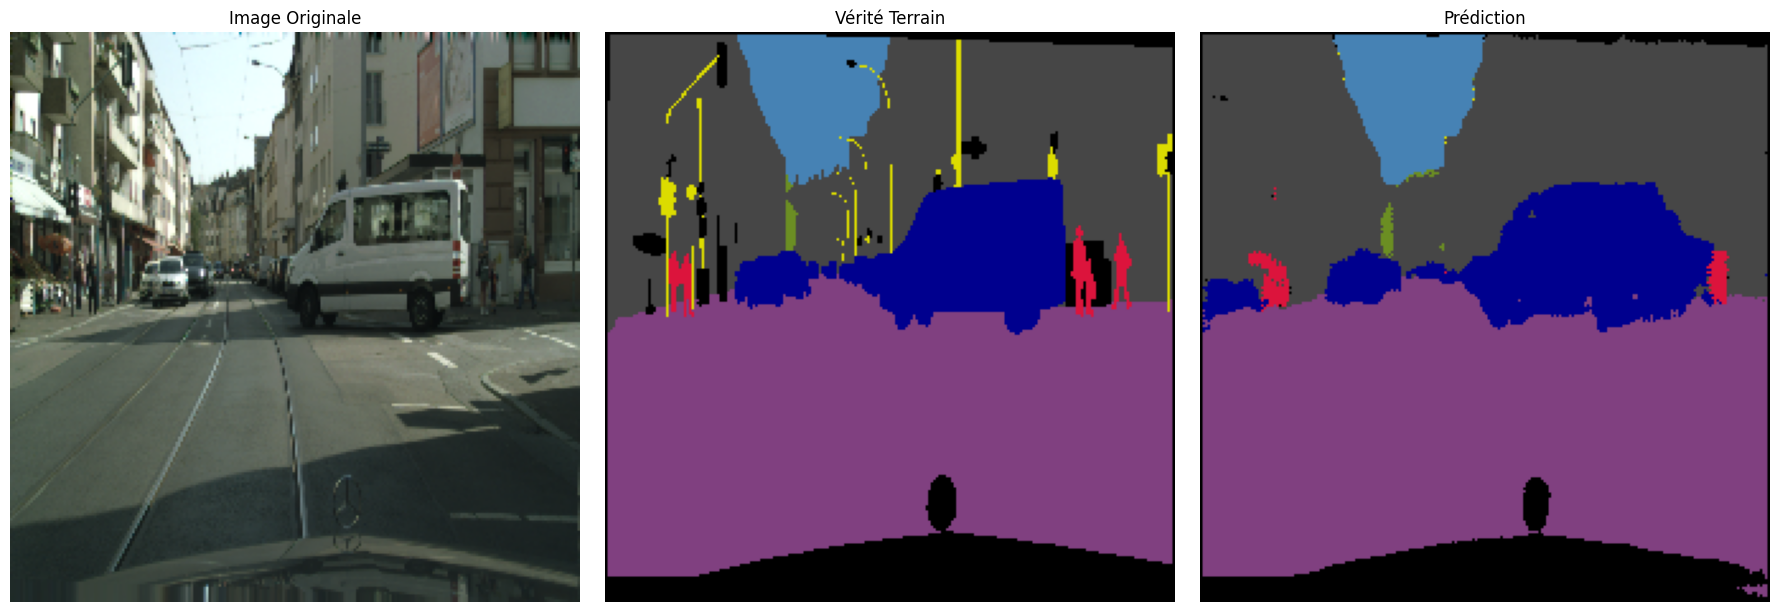

In [69]:
# 2. Prédiction sur une image du dataset de test
print("\n" + "="*50)
print("PRÉDICTION SUR IMAGE DU DATASET DE TEST")
print("="*50)

test_result = predict_from_test_dataset(model, config, test_dataset, image_index=5)

# Visualiser avec vérité terrain
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(test_result['original_image'])
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Vérité terrain colorée
true_colored = np.zeros((*test_result['true_mask'].shape, 3), dtype=np.uint8)
for class_id in range(config['num_classes']):
    true_colored[test_result['true_mask'] == class_id] = config['group_colors'][class_id]

axes[1].imshow(true_colored)
axes[1].set_title("Vérité Terrain")
axes[1].axis('off')

# Prédiction colorée
pred_colored = np.zeros((*test_result['prediction_mask'].shape, 3), dtype=np.uint8)
for class_id in range(config['num_classes']):
    pred_colored[test_result['prediction_mask'] == class_id] = config['group_colors'][class_id]

axes[2].imshow(pred_colored)
axes[2].set_title("Prédiction")
axes[2].axis('off')

plt.tight_layout()
plt.show()


🧠 PRÉDICTION SUR IMAGE EXTERNE
📂 Image sélectionnée : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\data\cityscapes\leftImg8bit\val\frankfurt\frankfurt_000000_000294_leftImg8bit.png
📷 Chargement de l'image : frankfurt_000000_000294_leftImg8bit.png
🔄 Préprocessing de l'image...
   📏 Taille originale : (1024, 2048, 3)
   📦 Taille pour prédiction : (1, 224, 224, 3)
🧠 Prédiction en cours...
✅ Prédiction terminée !
📊 Répartition des classes détectées :
   flat                :    19653 px ( 39.2%)
   construction        :    19577 px ( 39.0%)
   void                :     5661 px ( 11.3%)
   vehicle             :     2517 px (  5.0%)
   nature              :      992 px (  2.0%)
   human               :      870 px (  1.7%)
   sky                 :      866 px (  1.7%)
   object              :       40 px (  0.1%)
🖼️ Visualisation de la prédiction en cours...


C:\Users\touad\AppData\Local\Temp\ipykernel_27592\2332610071.py:68: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\touad\AppData\Local\Temp\ipykernel_27592\2332610071.py:72: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches="tight")


💾 Visualisation sauvegardée dans : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_001_baseline\results\prediction_example.png


C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


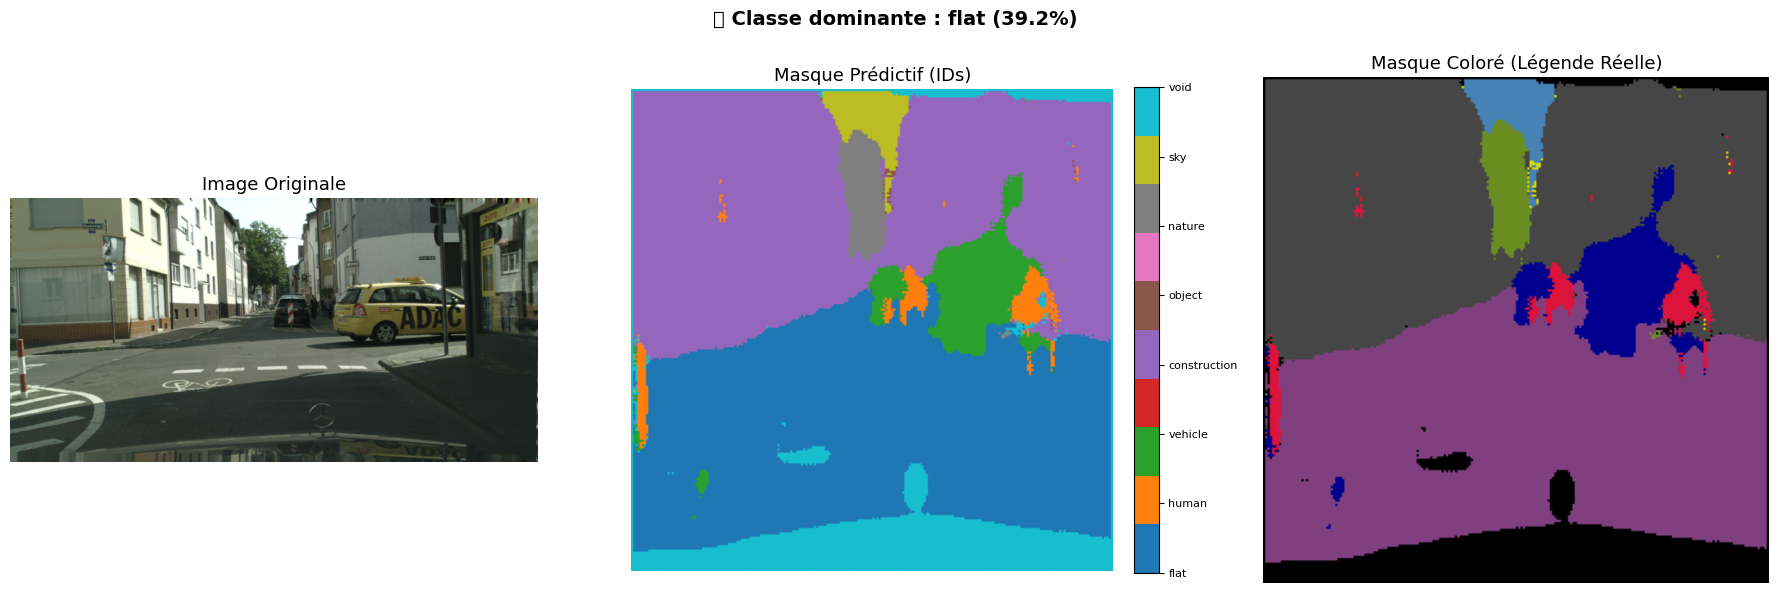


📊 Statistiques détaillées par classe :
  class_name  pixel_count  percentage
        flat        19653       39.17
construction        19577       39.02
        void         5661       11.28
     vehicle         2517        5.02
      nature          992        1.98
       human          870        1.73
         sky          866        1.73
      object           40        0.08

📊 Tableau détaillé des classes détectées :
 class_id   class_name  pixel_count  percentage
        0         flat        19653        39.2
        3 construction        19577        39.0
        7         void         5661        11.3
        2      vehicle         2517         5.0
        5       nature          992         2.0
        1        human          870         1.7
        6          sky          866         1.7
        4       object           40         0.1


In [70]:
import os
import pandas as pd

# 3️⃣ Prédiction sur une image externe
print("\n" + "=" * 60)
print("🧠 PRÉDICTION SUR IMAGE EXTERNE")
print("=" * 60)

# 🔹 Exemple : chemin vers une image locale personnalisée
sample_image_path = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\datasets\sample_image.jpg"  # <-- remplace si tu veux une image précise

# 🔹 Ou, automatiquement, on prend une image du dossier Cityscapes 'val'
if not os.path.exists(sample_image_path):
    images_dir = os.path.join(cityscapes_dir, "leftImg8bit", "val")
    sample_image_path = None

    for city in os.listdir(images_dir):
        city_dir = os.path.join(images_dir, city)
        if os.path.isdir(city_dir):
            for file_name in os.listdir(city_dir):
                if file_name.endswith("_leftImg8bit.png"):
                    sample_image_path = os.path.join(city_dir, file_name)
                    break
            if sample_image_path:
                break

# Vérification de l'image trouvée
if sample_image_path and os.path.exists(sample_image_path):
    print(f"📂 Image sélectionnée : {sample_image_path}")

    # 🧩 Prédiction
    external_result = predict_single_image(
        model,
        config,
        image_path=sample_image_path
    )

    # 🔹 Définir le chemin de sauvegarde dans le répertoire d’expérience
    save_path = os.path.join(
        r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport",
        "experiments",
        "exp_001_baseline",
        "results",
        "prediction_example.png"
    )
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 🎨 Visualisation et sauvegarde
    visualize_prediction(external_result, config, save_path=save_path)

    # 📊 Affichage du tableau des statistiques
    print("\n📊 Tableau détaillé des classes détectées :")
    stats_df = pd.DataFrame(external_result["class_statistics"])
    print(stats_df.to_string(index=False, float_format="%.1f"))

else:
    print("❌ Aucune image trouvée pour la prédiction.")
    print("➡️ Vérifie le chemin défini dans `sample_image_path`.")


In [72]:
import json
import os
from datetime import datetime

def generate_experiment_report(experiment_name, base_dir):
    """
    Génère un rapport Markdown détaillé d'une expérience de segmentation.
    """

    # === 1️⃣ Localisation des fichiers ===
    exp_dir = os.path.join(base_dir, "experiments", experiment_name)
    results_dir = os.path.join(exp_dir, "results")
    config_path = os.path.join(results_dir, "experiment_config.json")
    test_results_path = os.path.join(results_dir, "test_results.json")

    if not os.path.exists(config_path):
        raise FileNotFoundError(f"❌ Fichier de configuration introuvable : {config_path}")

    # Charger les fichiers JSON
    with open(config_path, "r") as f:
        config = json.load(f)

    test_results = {}
    if os.path.exists(test_results_path):
        with open(test_results_path, "r") as f:
            test_results = json.load(f)

    # === 2️⃣ Informations principales ===
    exp_name = config.get("exp_name", experiment_name)
    desc = config.get("description", "N/A")
    params = config.get("params", {})
    num_classes = config.get("num_classes", 8)
    group_names = config.get("group_names", ["N/A"])
    date_eval = test_results.get("test_date", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    # === 3️⃣ Métriques principales ===
    metrics = test_results.get("results", {})
    loss = metrics.get("test_loss", "N/A")
    acc = metrics.get("test_sparse_categorical_accuracy", "N/A")
    mean_iou = metrics.get("test_mean_io_u", "N/A")

    # === 4️⃣ Génération du contenu Markdown ===
    report_md = f"""## Rapport d'Évaluation - Modèle de Segmentation Sémantique

## 🏷️ Identification de l'Expérience
- **Nom de l'expérience**: {exp_name}
- **Description**: {desc}
- **Date d'évaluation**: {date_eval}

## ⚙️ Configuration du Modèle
- **Architecture**: {config.get("architecture", "MobileNetV2-UNet")}
- **Backbone**: {config.get("backbone", "MobileNetV2 (ImageNet pré-entraîné)")}
- **Encoder trainable**: {params.get("base_model_trainable", False)}
- **Classes de segmentation**: {num_classes}
- **Groupes de classes**: {", ".join(group_names)}

## 📋 Paramètres d'Entraînement
- **Taille d'image**: {tuple(config.get("img_size", (224, 224)))}
- **Batch size**: {params.get("batch_size", "N/A")}
- **Époques d'entraînement**: {params.get("epochs", "N/A")}
- **Taux d'apprentissage**: {params.get("learning_rate", "N/A")}
- **Division validation**: {params.get("validation_split", "N/A")}
- **Augmentation de données**: {params.get("augmentation", True)}

## 📊 Performances Finales sur Dataset de Test
- **Perte finale**: {loss}
- **Précision finale**: {acc}
- **MeanIoU finale**: {mean_iou}

## 🎯 Dataset et Évaluation
- **Dataset**: Cityscapes (segmentation urbaine)
- **Split utilisé pour test**: Dataset 'val' original (évite data leakage)
- **Nombre d'images de test**: ~500 images
- **Méthode d'évaluation**: IoU par classe, précision globale, matrice de confusion

## 📈 Mapping des Classes
Les classes originales de Cityscapes ont été regroupées en catégories pertinentes pour la navigation autonome:

""" + "\n".join(
        [f"{i+1}. **{name}** ({i})" for i, name in enumerate(group_names)]
    ) + f"""

## 🚗 Applications et Déploiement
- **Cas d'usage**: Système de vision pour véhicules autonomes
- **Format de modèle**: Keras (.keras) - compatible TensorFlow Lite
- **Optimisations**: MobileNetV2 conçu pour l'efficacité mobile
- **Intégration**: API FastAPI + Frontend Next.js (en développement)

## 📂 Artefacts Générés
- **Modèle entraîné**: `experiments/{experiment_name}/models/cityscapes_segmentation_model.keras`
- **Configuration**: `experiments/{experiment_name}/results/experiment_config.json`
- **Historique d'entraînement**: `experiments/{experiment_name}/results/training_history.json`
- **Métriques détaillées**: `experiments/{experiment_name}/results/`
- **Visualisations**: Matrice de confusion, exemples de prédictions

## 🔄 Suivi et Reproductibilité
- **Structure d'expériences**: Organisation modulaire par dossiers
- **Intégration MLflow**: Suivi des métriques et artefacts
- **Graine aléatoire**: 42 (reproductibilité garantie)
- **Environnement**: TensorFlow 2.18.0, Keras 3.8.0

## 📝 Notes Techniques
- Le modèle utilise `SparseCategoricalCrossentropy` comme fonction de perte.
- L'encoder MobileNetV2 peut être gelé ou entraînable selon la configuration.
- La segmentation est réalisée à 224x224 puis peut être redimensionnée.
- L'augmentation de données inclut flip horizontal et variation de luminosité.

## 🎯 Recommandations
1. **Améliorer les performances** : Entraîner avec encoder dégelé ou plus d'epochs.
2. **Pour le déploiement** : Conversion en TensorFlow Lite pour usage mobile embarqué.
3. **Pour l'évaluation** : Comparer Mean IoU entre expériences pour analyse.
4. **Pour la production** : Étendre l'entraînement à d'autres environnements urbains.

---
*Rapport généré automatiquement le {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}*
"""

    # === 5️⃣ Sauvegarde du rapport ===
    report_path = os.path.join(results_dir, "evaluation_report.md")
    with open(report_path, "w", encoding="utf-8") as f:
        f.write(report_md)

    print(f"✅ Rapport Markdown généré : {report_path}")

    return report_md


In [73]:
# === Paramètres ===
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"
experiment_name = "exp_003_finetune"

# === Génération du rapport ===
report_text = generate_experiment_report(experiment_name, base_dir)

# === Affichage Markdown dans le notebook ===
from IPython.display import Markdown, display
display(Markdown(report_text))


✅ Rapport Markdown généré : C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport\experiments\exp_003_finetune\results\evaluation_report.md


## Rapport d'Évaluation - Modèle de Segmentation Sémantique

## 🏷️ Identification de l'Expérience
- **Nom de l'expérience**: exp_003_finetune
- **Description**: Fine-tuning MobileNetV2 avec encoder dÃ©gelÃ© (exp_003)
- **Date d'évaluation**: 2025-10-25 19:22:38

## ⚙️ Configuration du Modèle
- **Architecture**: MobileNetV2-UNet
- **Backbone**: MobileNetV2 (ImageNet pré-entraîné)
- **Encoder trainable**: True
- **Classes de segmentation**: 8
- **Groupes de classes**: N/A

## 📋 Paramètres d'Entraînement
- **Taille d'image**: (224, 224)
- **Batch size**: 8
- **Époques d'entraînement**: 5
- **Taux d'apprentissage**: 1e-05
- **Division validation**: 0.2
- **Augmentation de données**: False

## 📊 Performances Finales sur Dataset de Test
- **Perte finale**: 0.39918768405914307
- **Précision finale**: N/A
- **MeanIoU finale**: N/A

## 🎯 Dataset et Évaluation
- **Dataset**: Cityscapes (segmentation urbaine)
- **Split utilisé pour test**: Dataset 'val' original (évite data leakage)
- **Nombre d'images de test**: ~500 images
- **Méthode d'évaluation**: IoU par classe, précision globale, matrice de confusion

## 📈 Mapping des Classes
Les classes originales de Cityscapes ont été regroupées en catégories pertinentes pour la navigation autonome:

1. **N/A** (0)

## 🚗 Applications et Déploiement
- **Cas d'usage**: Système de vision pour véhicules autonomes
- **Format de modèle**: Keras (.keras) - compatible TensorFlow Lite
- **Optimisations**: MobileNetV2 conçu pour l'efficacité mobile
- **Intégration**: API FastAPI + Frontend Next.js (en développement)

## 📂 Artefacts Générés
- **Modèle entraîné**: `experiments/exp_003_finetune/models/cityscapes_segmentation_model.keras`
- **Configuration**: `experiments/exp_003_finetune/results/experiment_config.json`
- **Historique d'entraînement**: `experiments/exp_003_finetune/results/training_history.json`
- **Métriques détaillées**: `experiments/exp_003_finetune/results/`
- **Visualisations**: Matrice de confusion, exemples de prédictions

## 🔄 Suivi et Reproductibilité
- **Structure d'expériences**: Organisation modulaire par dossiers
- **Intégration MLflow**: Suivi des métriques et artefacts
- **Graine aléatoire**: 42 (reproductibilité garantie)
- **Environnement**: TensorFlow 2.18.0, Keras 3.8.0

## 📝 Notes Techniques
- Le modèle utilise `SparseCategoricalCrossentropy` comme fonction de perte.
- L'encoder MobileNetV2 peut être gelé ou entraînable selon la configuration.
- La segmentation est réalisée à 224x224 puis peut être redimensionnée.
- L'augmentation de données inclut flip horizontal et variation de luminosité.

## 🎯 Recommandations
1. **Améliorer les performances** : Entraîner avec encoder dégelé ou plus d'epochs.
2. **Pour le déploiement** : Conversion en TensorFlow Lite pour usage mobile embarqué.
3. **Pour l'évaluation** : Comparer Mean IoU entre expériences pour analyse.
4. **Pour la production** : Étendre l'entraînement à d'autres environnements urbains.

---
*Rapport généré automatiquement le 2025-10-25 19:30:04*


In [40]:
import numpy as np
import tensorflow as tf

def calculate_mean_iou_manual(model, test_dataset, num_classes):
    """
    Calcule manuellement le Mean IoU (Intersection over Union)
    sur l'ensemble du dataset de test.

    Args:
        model: Modèle Keras entraîné.
        test_dataset: tf.data.Dataset contenant (images, masques réels).
        num_classes: Nombre total de classes de segmentation.

    Returns:
        tuple: (mean_iou, iou_per_class)
    """
    print("🧮 Calcul manuel du Mean IoU...")
    total_batches = tf.data.experimental.cardinality(test_dataset).numpy()

    all_true_masks = []
    all_pred_masks = []

    # ⚙️ Parcourir le dataset de test
    for batch_idx, (images, true_masks) in enumerate(test_dataset):
        # Prédictions
        predictions = model.predict(images, verbose=0)
        pred_masks = tf.argmax(predictions, axis=-1)

        # Conversion en numpy
        all_true_masks.extend(true_masks.numpy())
        all_pred_masks.extend(pred_masks.numpy())

        if (batch_idx + 1) % 10 == 0 or batch_idx == total_batches - 1:
            print(f"   ✅ {batch_idx + 1}/{total_batches} batches traités...")

    # Conversion finale en arrays numpy
    all_true_masks = np.array(all_true_masks, dtype=np.uint8)
    all_pred_masks = np.array(all_pred_masks, dtype=np.uint8)

    # Vérification
    print(f"📦 Total d'images évaluées : {len(all_true_masks)}")

    # 🧠 Calcul IoU par classe
    ious = []
    for class_id in range(num_classes):
        true_binary = (all_true_masks == class_id)
        pred_binary = (all_pred_masks == class_id)

        intersection = np.logical_and(true_binary, pred_binary).sum()
        union = np.logical_or(true_binary, pred_binary).sum()

        if union > 0:
            iou = intersection / union
        else:
            iou = 0.0

        ious.append(iou)

    mean_iou = np.mean(ious)

    # 🧾 Affichage résumé
    print("\n📊 IoU par classe :")
    for i, iou in enumerate(ious):
        print(f"   Classe {i}: {iou:.4f}")

    print(f"\n✅ Mean IoU global: {mean_iou:.4f}")

    return mean_iou, ious


In [42]:
import os
import json
from datetime import datetime
import tensorflow as tf
import keras  # ✅ pour accéder à keras.__version__

# === ⚙️ Paramètres de base ===
experiment_name = "exp_002_no_augmentation"
base_dir = r"C:\Users\touad\Projects-Openclassrooms\Projet-Future-Vision-Transport"

# === 📦 Évaluation finale ===
print("🔍 Évaluation finale du modèle...")
final_metrics = trained_model.evaluate(test_dataset, verbose=1)

# === 🧮 Gestion des métriques selon le modèle ===
final_loss, final_accuracy, final_miou = None, None, None

if len(trained_model.metrics_names) == 2:
    final_loss, final_accuracy = final_metrics
    print("\n🧮 MeanIoU non disponible dans le modèle, calcul manuel...")
    try:
        final_miou, class_ious = calculate_mean_iou_manual(trained_model, test_dataset, config['num_classes'])
        print("\n📊 IoU par classe:")
        for class_name, iou in zip(config['group_names'], class_ious):
            print(f"   {class_name:>12}: {iou:.4f}")
    except Exception as e:
        print(f"❌ Erreur lors du calcul du MeanIoU: {e}")
        final_miou = None

elif len(trained_model.metrics_names) == 3:
    final_loss, final_accuracy, final_miou = final_metrics
else:
    final_loss = final_metrics[0]
    if len(final_metrics) > 1:
        final_accuracy = final_metrics[1]
    if len(final_metrics) > 2:
        final_miou = final_metrics[2]

print("\n📊 Résumé des performances du modèle:")
print(f"   Loss finale: {final_loss:.4f}")
if final_accuracy is not None:
    print(f"   Précision finale: {final_accuracy:.4f}")
if final_miou is not None:
    print(f"   MeanIoU finale: {final_miou:.4f}")
else:
    print("   MeanIoU finale: Non calculable")

# === 📁 Chargement de la configuration ===
exp_config_path = os.path.join(base_dir, "experiments", experiment_name, "results", "experiment_config.json")
if not os.path.exists(exp_config_path):
    raise FileNotFoundError(f"❌ Fichier introuvable : {exp_config_path}")

with open(exp_config_path, 'r', encoding='utf-8') as f:
    exp_config = json.load(f)

# === 📈 Historique d'entraînement ===
history_path = os.path.join(base_dir, "experiments", experiment_name, "results", "training_history.json")
training_epochs = "N/A"
if os.path.exists(history_path):
    with open(history_path, 'r', encoding='utf-8') as f:
        history_data = json.load(f)
    training_epochs = len(history_data.get('loss', []))

# === 🧾 Formatage des valeurs ===
final_accuracy_str = f"{final_accuracy:.4f}" if final_accuracy is not None else "Non disponible"
final_miou_str = f"{final_miou:.4f}" if final_miou is not None else "Non disponible"
img_size = exp_config.get("params", {}).get("img_size", (224, 224))

# === 📝 Création du rapport Markdown ===
rapport = f"""
# Rapport d'Évaluation - Modèle de Segmentation Sémantique

## 🏷️ Identification de l'Expérience
- **Nom de l'expérience**: {experiment_name}
- **Description**: {exp_config.get('description', 'Non spécifiée')}
- **Date d'évaluation**: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## ⚙️ Configuration du Modèle
- **Architecture**: MobileNetV2-UNet
- **Backbone**: MobileNetV2 (ImageNet pré-entraîné)
- **Encoder trainable**: {exp_config.get('params', {}).get('base_model_trainable', 'Non spécifié')}
- **Classes de segmentation**: {config['num_classes']} groupes
- **Groupes de classes**: {', '.join(config['group_names'])}

## 📋 Paramètres d'Entraînement
- **Taille d'image**: {img_size}
- **Batch size**: {exp_config.get('params', {}).get('batch_size', 'Non spécifié')}
- **Époques d'entraînement**: {training_epochs}
- **Taux d'apprentissage**: {exp_config.get('params', {}).get('learning_rate', 'Non spécifié')}
- **Division validation**: {exp_config.get('params', {}).get('validation_split', 'Non spécifiée')}
- **Augmentation de données**: {exp_config.get('params', {}).get('augmentation', 'Non spécifiée')}

## 📊 Performances Finales sur Dataset de Test
- **Perte finale**: {final_loss:.4f}
- **Précision finale**: {final_accuracy_str}
- **MeanIoU finale**: {final_miou_str}

## 🎯 Dataset et Évaluation
- **Dataset**: Cityscapes (segmentation urbaine)
- **Split utilisé pour test**: Dataset 'val' original
- **Nombre d'images de test**: ~500 images
- **Méthode d'évaluation**: IoU par classe, précision globale, matrice de confusion

## 📈 Mapping des Classes
""" + "\n".join([f"{i+1}. **{name}** ({i})" for i, name in enumerate(config['group_names'])]) + f"""

## 🚗 Applications et Déploiement
- **Cas d'usage**: Système de vision pour véhicules autonomes
- **Format du modèle**: `.keras` (TensorFlow)
- **Optimisation mobile**: MobileNetV2 pour efficacité embarquée
- **Intégration prévue**: API FastAPI + Frontend Next.js

## 🔄 Suivi et Reproductibilité
- **Graine aléatoire**: 42
- **Environnement**: TensorFlow {tf.__version__}, Keras {keras.__version__}

---
*Rapport généré automatiquement le {datetime.now().strftime("%Y-%m-%d à %H:%M:%S")}*
"""

# === 💾 Sauvegarde ===
results_dir = os.path.join(base_dir, "experiments", experiment_name, "results")
os.makedirs(results_dir, exist_ok=True)

rapport_path = os.path.join(results_dir, "rapport_final.md")
with open(rapport_path, "w", encoding="utf-8") as f:
    f.write(rapport)
print(f"\n📄 Rapport sauvegardé : {rapport_path}")

# === Version JSON structurée ===
rapport_json = {
    "experiment_name": experiment_name,
    "description": exp_config.get("description", ""),
    "evaluation_date": datetime.now().isoformat(),
    "model_config": {
        "architecture": "MobileNetV2-UNet",
        "num_classes": config["num_classes"],
        "class_names": config["group_names"],
        "input_size": img_size
    },
    "training_params": exp_config.get("params", {}),
    "final_performance": {
        "loss": float(final_loss),
        "accuracy": float(final_accuracy) if final_accuracy is not None else None,
        "mean_iou": float(final_miou) if final_miou is not None else None
    }
}

rapport_json_path = os.path.join(results_dir, "rapport_final.json")
with open(rapport_json_path, "w", encoding="utf-8") as f:
    json.dump(rapport_json, f, indent=4, ensure_ascii=False)
print(f"📊 Rapport JSON sauvegardé : {rapport_json_path}")


🔍 Évaluation finale du modèle...
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.3947 - sparse_categorical_accuracy: 0.8789

🧮 MeanIoU non disponible dans le modèle, calcul manuel...
🧮 Calcul manuel du Mean IoU...
   ✅ 10/63 batches traités...
   ✅ 20/63 batches traités...
   ✅ 30/63 batches traités...
   ✅ 40/63 batches traités...
   ✅ 50/63 batches traités...
   ✅ 60/63 batches traités...
   ✅ 63/63 batches traités...
📦 Total d'images évaluées : 500

📊 IoU par classe :
   Classe 0: 0.9088
   Classe 1: 0.3549
   Classe 2: 0.7435
   Classe 3: 0.7503
   Classe 4: 0.0184
   Classe 5: 0.7985
   Classe 6: 0.8315
   Classe 7: 0.6473

✅ Mean IoU global: 0.6316

📊 IoU par classe:
           flat: 0.9088
          human: 0.3549
        vehicle: 0.7435
   construction: 0.7503
         object: 0.0184
         nature: 0.7985
            sky: 0.8315
           void: 0.6473

📊 Résumé des performances du modèle:
   Loss finale: 0.3947
   Précision finale: 0.8789
   MeanIoU finale: 0.6316

📄 Rappo